In [2]:
import os
from datasets import load_dataset
import datasets
from datasets import Value, Sequence
import sys
import math
import transformers
import json
import matplotlib.pyplot as plt

cache_dir = '/users/PDS0352/wyang107/project/LCEG/model_cache/data'

/users/PDS0352/wyang107/miniconda3/envs/lceg2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# InfiniteBench = load_dataset('xinrongzhang2022/InfiniteBench', cache_dir=cache_dir, streaming= True)
ft = datasets.Features({"id": Value("int64"), "context": Value("string"), "input": Value("string"), "answer": Sequence(Value("string")), "options": Sequence(Value("string"))})
InfiniteBench = load_dataset("xinrongzhang2022/InfiniteBench", features=ft, cache_dir=cache_dir, streaming=True)

In [2]:
tokenizer = transformers.AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

/users/PDS0352/wyang107/miniconda3/envs/lceg/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [37]:
# 'gsm100'
# 'codeU'
# 'multidoc_qa'  'legal_contract_qa', 'financial_qa', 'natural_question' 'scientific_qa' 
# 'news_summ', 'patent_summ' 'tv_show_summ' 'review_summ',  'meeting_summ' 
dataset = load_dataset('L4NLP/LEval', name='gsm100'  ,split='test', cache_dir=cache_dir, streaming= True)

In [38]:
for data in dataset:
    print(data.keys())
    print(len(data['instructions']), len(data['outputs']), data['evaluation'])
    tokens = tokenizer.encode(data['input'])
    print(len(tokens))
    break

dict_keys(['instructions', 'input', 'outputs', 'source', 'evaluation'])
1 1 exam
5451


1. 先用llama 3.2/Qwen2的模型，来验证本身数据集没有问题
    - 预期的效果：模型越大，得分越多；长度越长，得分越少？
    - 可能出现的问题：
        - 模型本身能力特别强或者特别差，看不出差别；metric问题
        - 数据集本身有缺陷，比如multi-doc-qa，模型本身会有先验信息
        - prompt的影响比较大，比如llama2的multi-doc-sum，有时输出是每篇的sum，而不是多篇一起的sum
    - 结果
        - 整体符合模型越大，得分越多；长度越长，得分越少
    - 出现问题
        - counting star和kv retrivel出现相反的现象；
            - 这里采用选择题的方式，试着让模型直接输出答案？ 控制变量，但是模型似乎还是不下降
        - llama-8b的qa出现增长，可能模型已经记住答案
            - 采用filter的做法，看是否有下降
        - qa和sum的metric   
            - sum和qa用的分别是：rouge_score和qa_f1_score
            - 但是很多文章采用的是model-based metrics, 以此来增加区分性
        - 如何更好衡量模型的长文本能力？ metric 
            - 有些任务在8k就不高，但是增加长度变化比较小
            - 有些任务8k开始高，但是增加长度变化比较大

3. 任务
    - 类型目前分为
        - single-doc-qa，multi-doc-qa，single-doc-sum，multi-doc-sum: 带有干扰文章
        - sythetic： passage_count, passage-retrival, counting-stars， kv_retrivel, ruler
    - 根据基础文章生成不同长度的文章
    - 是否加入过滤操作：
        - 比如在无context和原文context的情况，模型回答是否差别不大，如果不大，说明模型本身带有先验信息，这条数据就不需要统计

4. 都没有问题，则可以开始实验
    - 不同模型，比如gpt，claude， gemini等
    - 不同长文本方法


In [2]:
paths = {
        # 'ntk':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama2-7b-hf-slimpajama-ntk-32k', 
        #  'pi': '/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama2-7b-hf-slimpajama-pi-32k/result.json',
         'llama-3.1-8B':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama-3.1-8B-Instruct',
         'llama-3.2-1B':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama-3.2-1B-Instruct',
         'llama-3.2-3B':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/llama-3.2-3B-Instruct',
         'Qwen2.5-7B':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/Qwen2.5-7B-Instruct',
         'Qwen2.5-14B':'/users/PDS0352/wyang107/project/LCEG/longbench_pro/pred/Qwen2.5-14B-Instruct'
         }
results = dict()
for k,p in paths.items():
    results[k] = json.load(open(os.path.join(p,'result.json'), 'r'))

In [3]:
from collections import defaultdict
draw_series = {'llama-3.2':{}, 'Qwen2.5':{}, 'llama-3.1':{}}
for model in results.keys():
    draw_things = defaultdict(list)
    for dataset,score in results[model].items():
        name = dataset.split('_')
        name, x = '_'.join(name[:-1]), int(name[-1])
        draw_things[name].append((x, score))
    draw_things = {key: draw_things[key] for key in sorted(draw_things)}
    for se in draw_series.keys():
        if se in model: draw_series[se][model] = draw_things

/tmp/ipykernel_761476/909886870.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(draw_things.keys()))


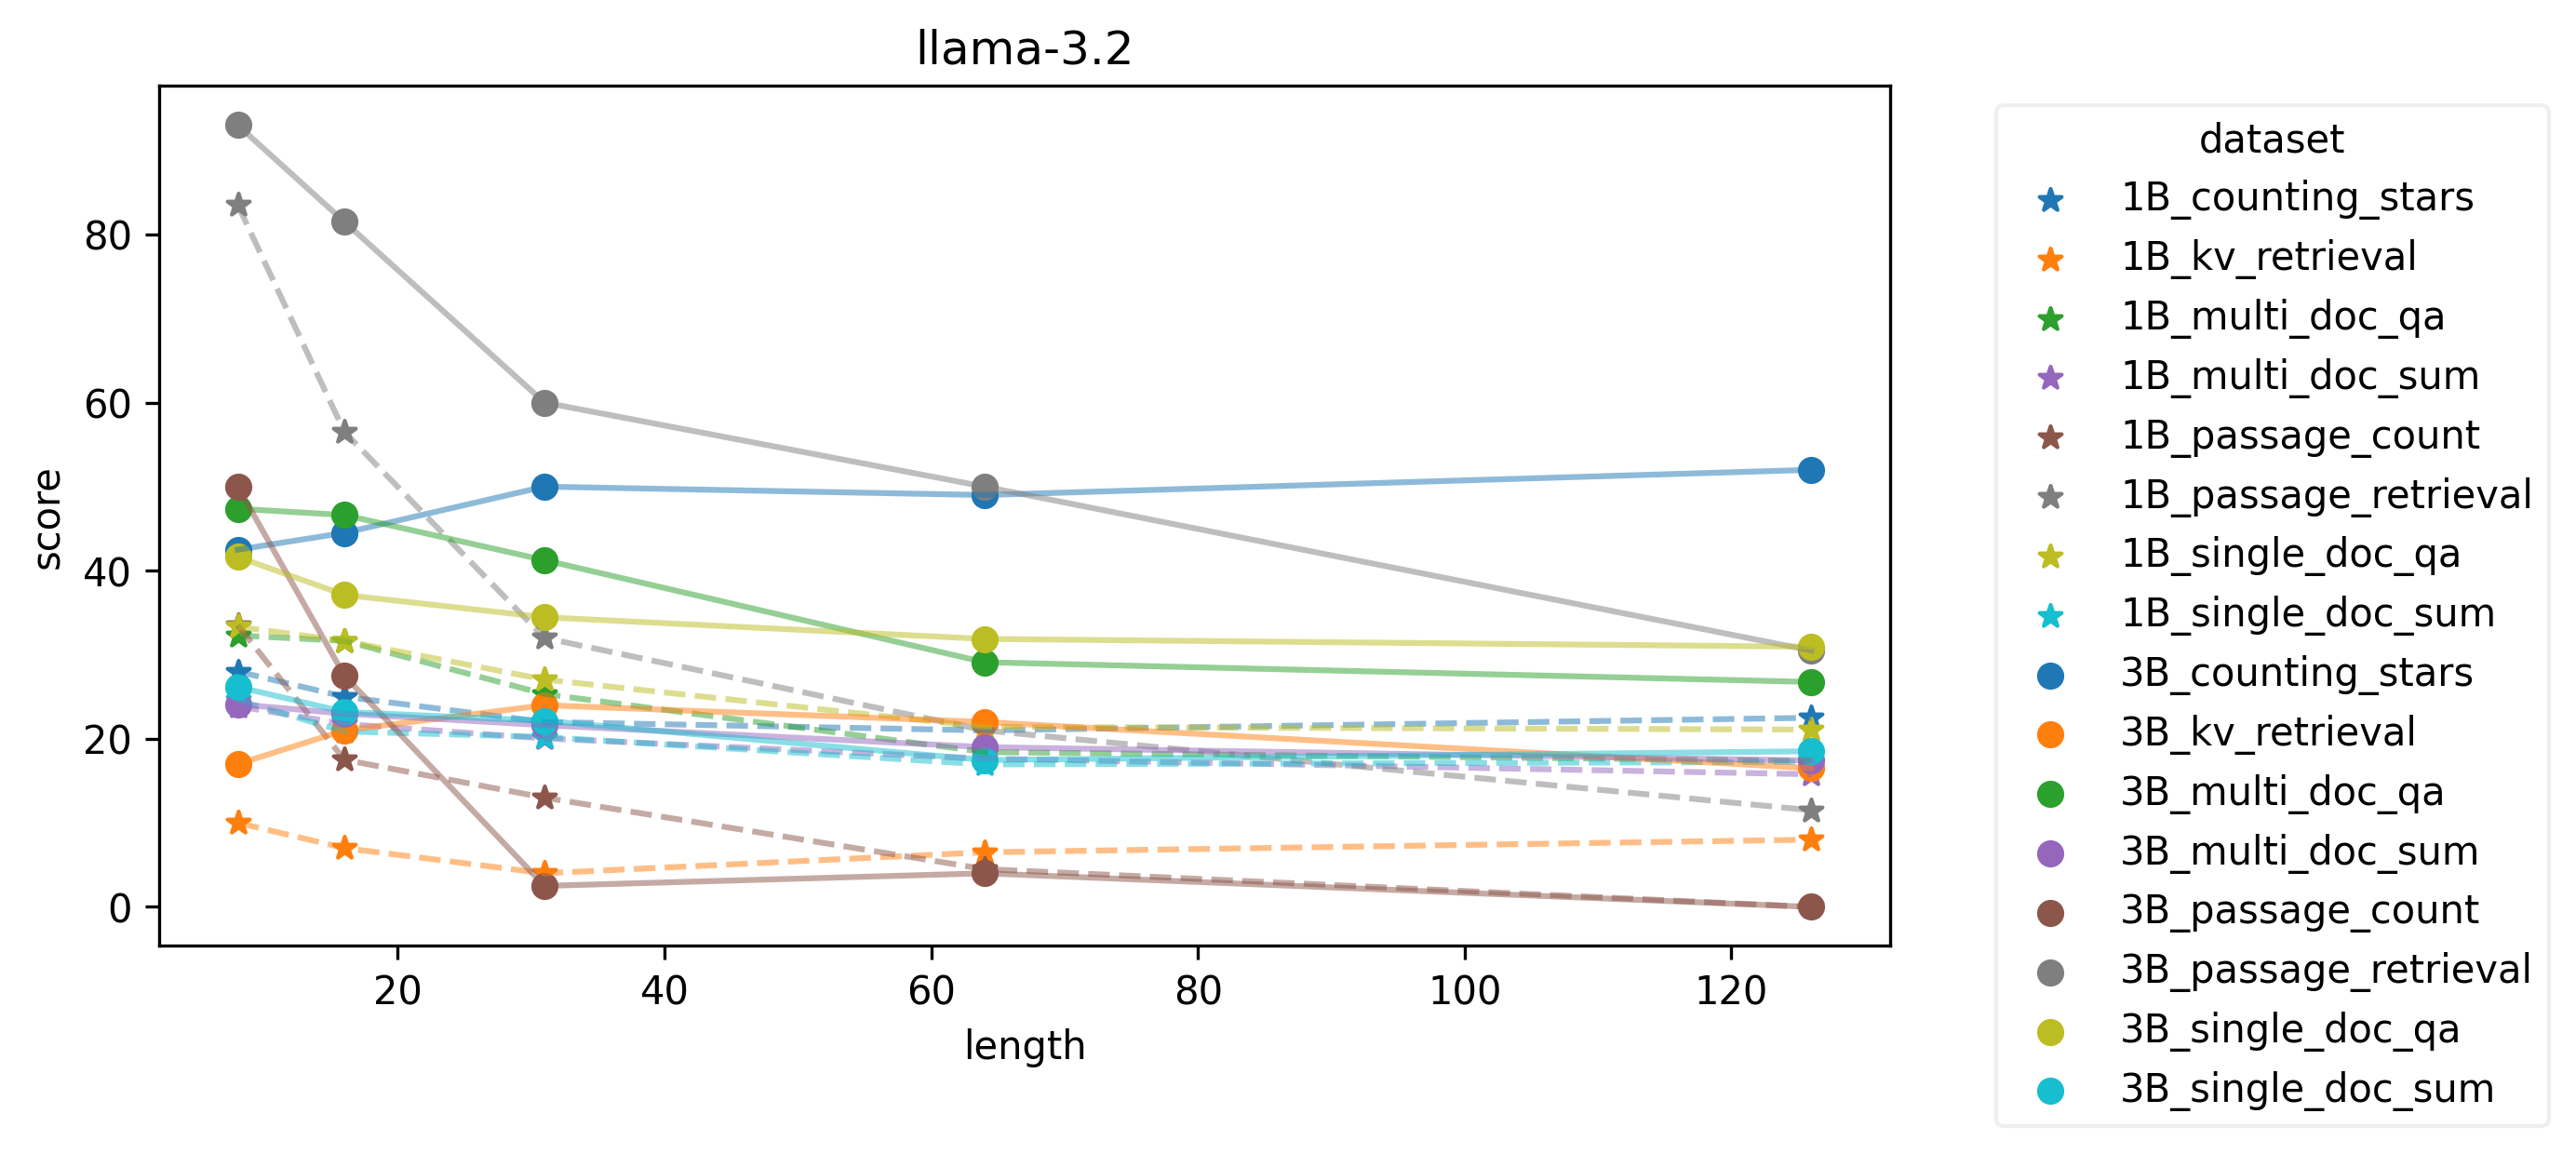

{'counting_stars': [(126, 52.0), (16, 44.5), (31, 50.0), (64, 49.0), (8, 42.5)], 'kv_retrieval': [(126, 16.5), (16, 21.0), (31, 24.0), (64, 22.0), (8, 17.0)], 'multi_doc_qa': [(126, 26.76), (16, 46.62), (31, 41.25), (64, 29.11), (8, 47.37)], 'multi_doc_sum': [(126, 17.42), (16, 22.99), (31, 21.62), (64, 19.01), (8, 24.12)], 'passage_count': [(126, 0.0), (16, 27.5), (31, 2.5), (64, 4.0), (8, 50.0)], 'passage_retrieval': [(126, 30.5), (16, 81.5), (31, 60.0), (64, 50.0), (8, 93.0)], 'single_doc_qa': [(126, 30.95), (16, 37.12), (31, 34.46), (64, 31.88), (8, 41.63)], 'single_doc_sum': [(126, 18.52), (16, 23.2), (31, 22.14), (64, 17.47), (8, 26.17)]}


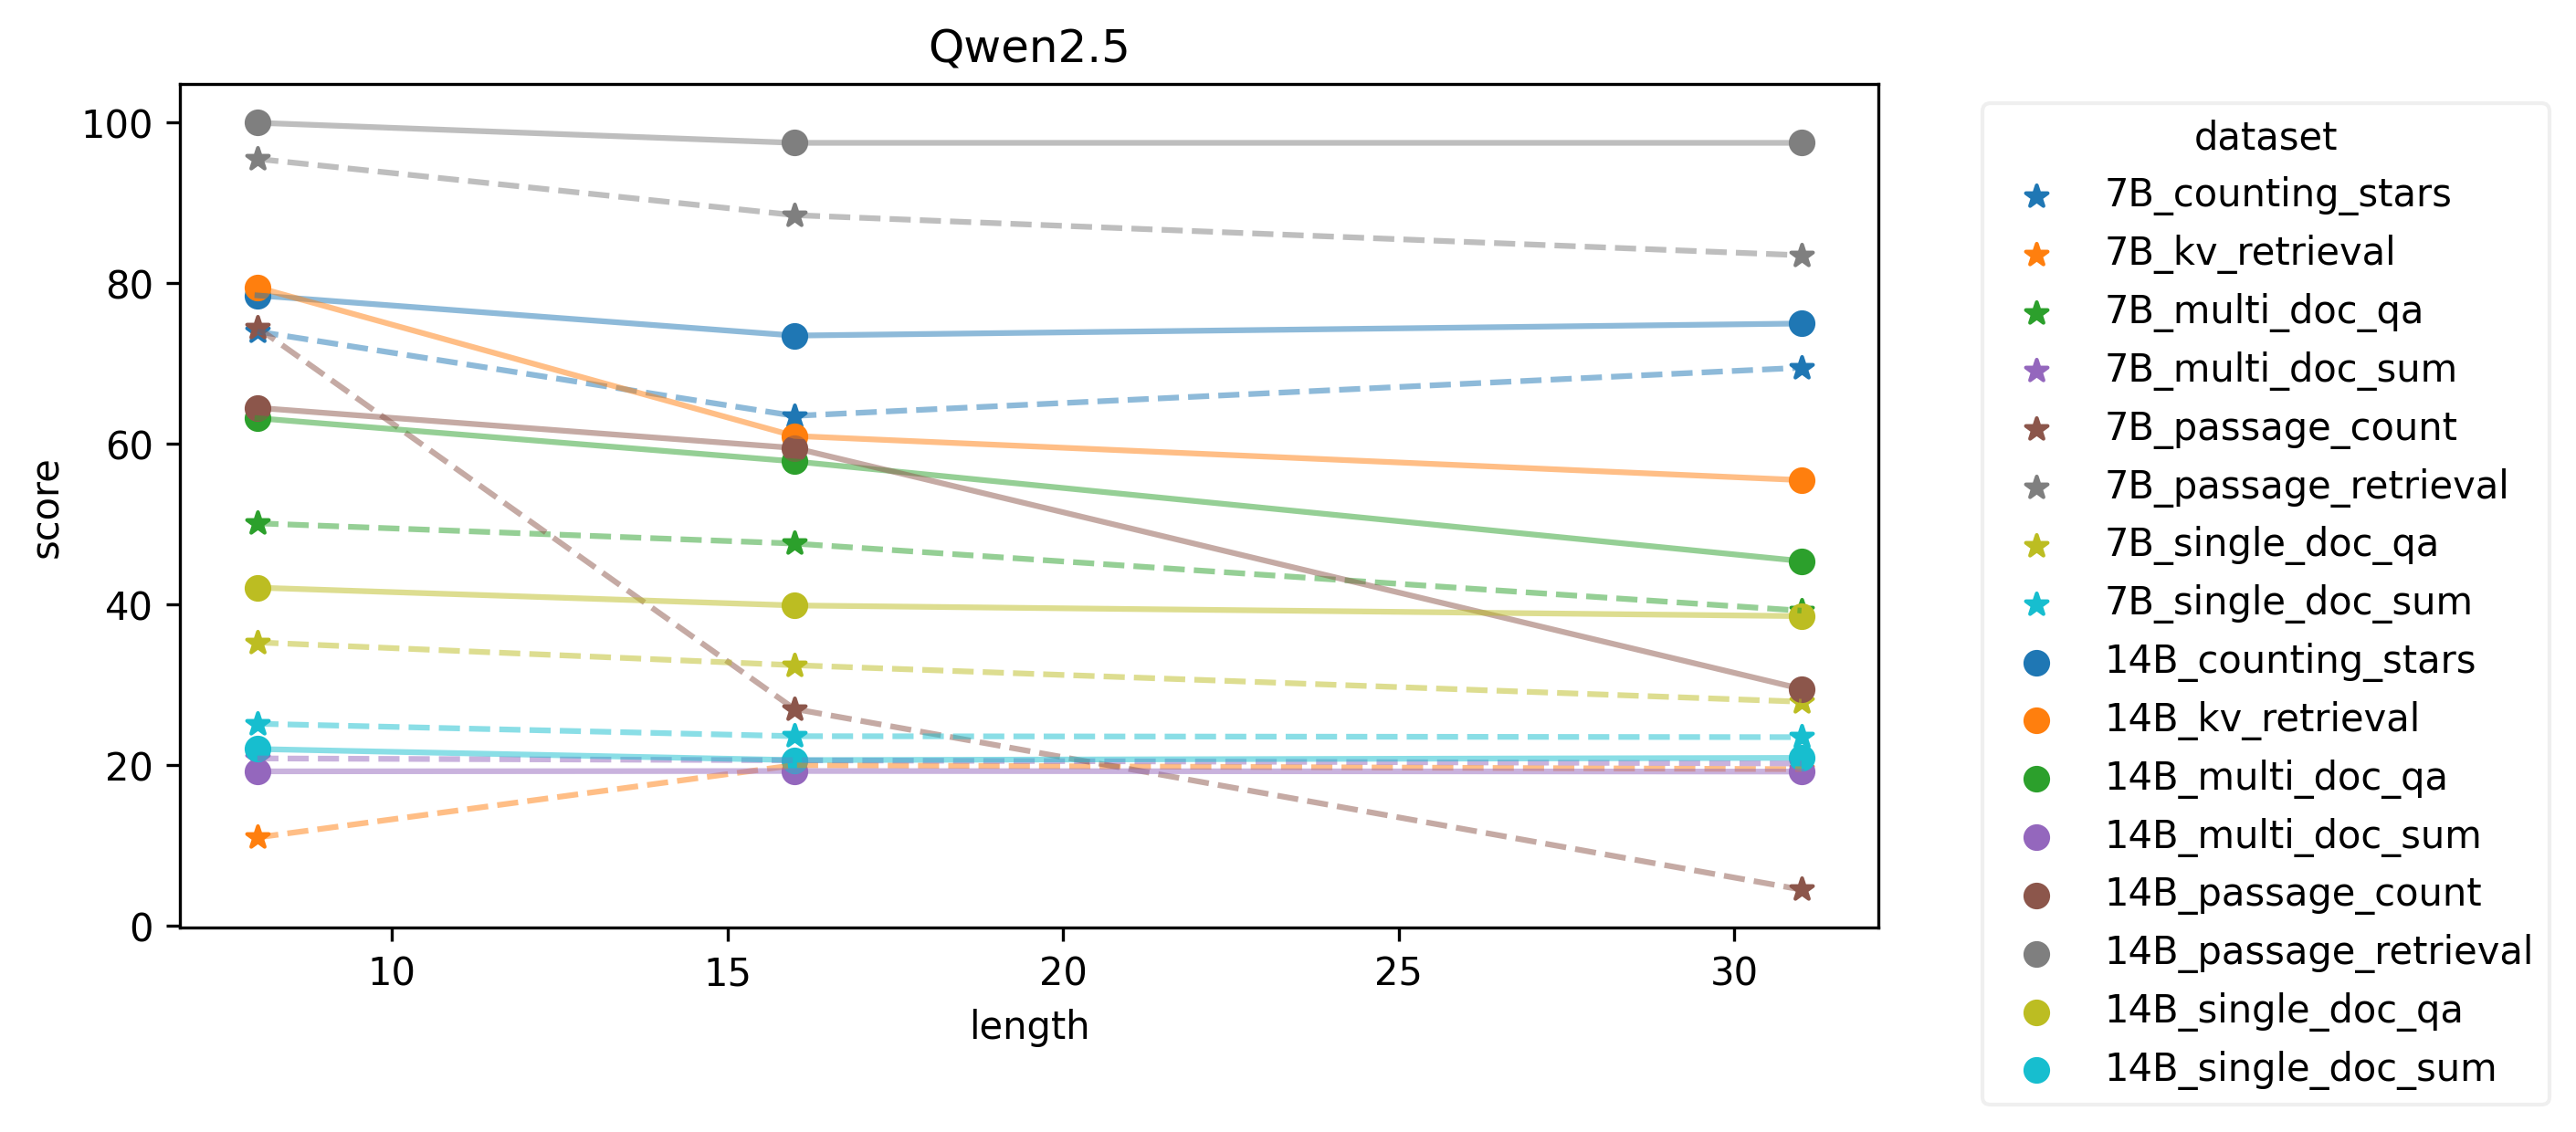

{'counting_stars': [(16, 73.5), (31, 75.0), (8, 78.5)], 'kv_retrieval': [(16, 61.0), (31, 55.5), (8, 79.5)], 'multi_doc_qa': [(16, 57.83), (31, 45.42), (8, 63.21)], 'multi_doc_sum': [(16, 19.27), (31, 19.2), (8, 19.23)], 'passage_count': [(16, 59.5), (31, 29.5), (8, 64.5)], 'passage_retrieval': [(16, 97.5), (31, 97.5), (8, 100.0)], 'single_doc_qa': [(16, 39.89), (31, 38.56), (8, 42.11)], 'single_doc_sum': [(16, 20.63), (31, 20.91), (8, 22.01)]}


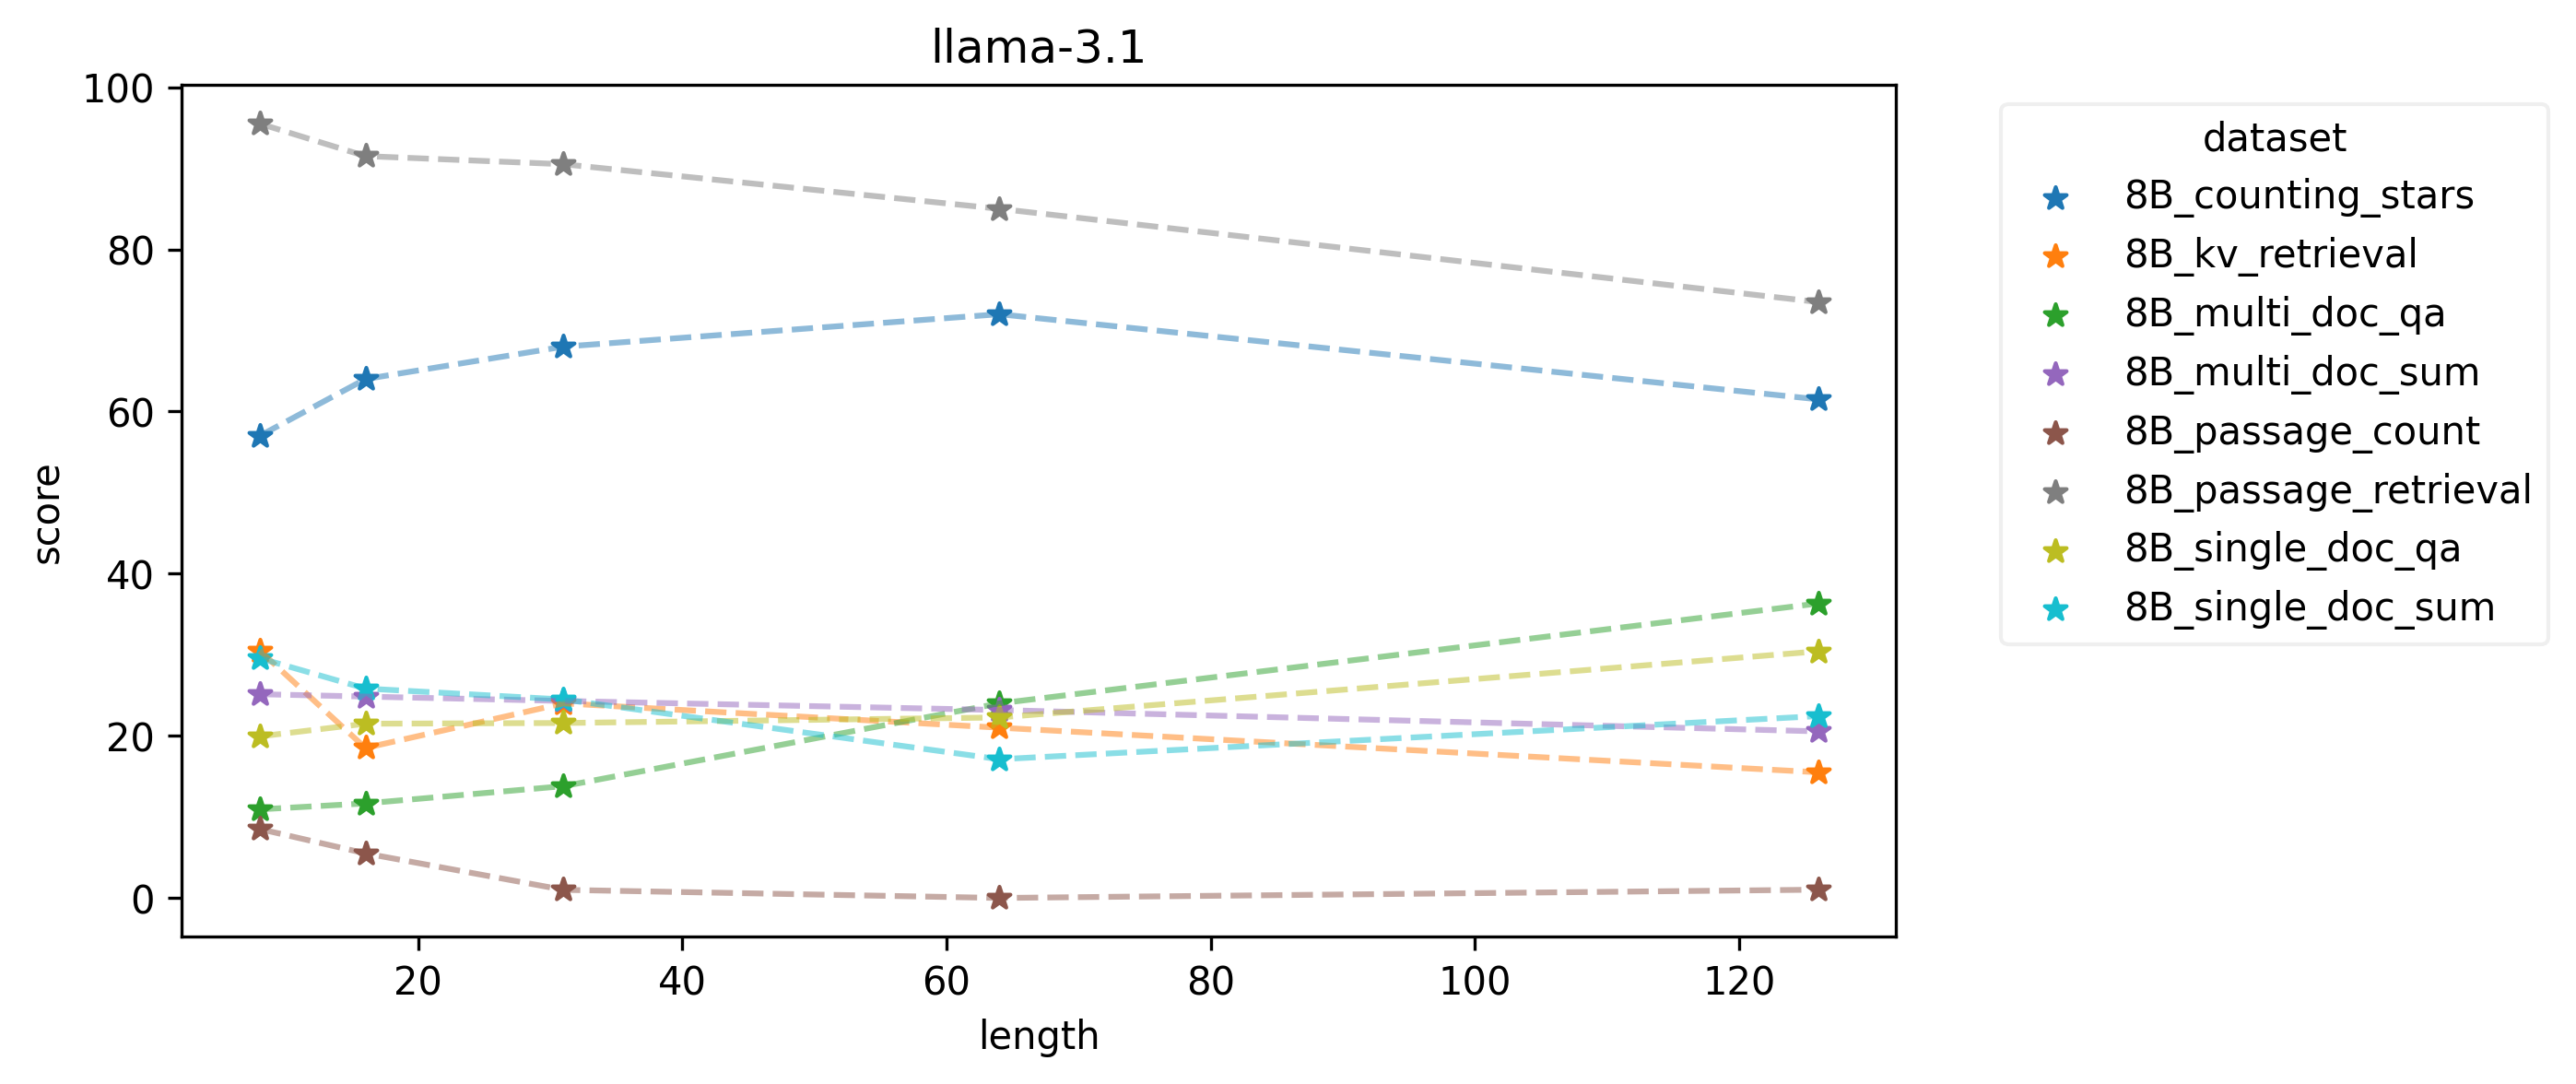

{'counting_stars': [(126, 61.5), (16, 64.0), (31, 68.0), (64, 72.0), (8, 57.0)], 'kv_retrieval': [(126, 15.5), (16, 18.5), (31, 24.0), (64, 21.0), (8, 30.5)], 'multi_doc_qa': [(126, 36.32), (16, 11.66), (31, 13.79), (64, 24.0), (8, 10.93)], 'multi_doc_sum': [(126, 20.55), (16, 24.84), (31, 24.3), (64, 23.18), (8, 25.13)], 'passage_count': [(126, 1.02), (16, 5.5), (31, 1.0), (64, 0.0), (8, 8.5)], 'passage_retrieval': [(126, 73.5), (16, 91.5), (31, 90.5), (64, 85.0), (8, 95.5)], 'single_doc_qa': [(126, 30.42), (16, 21.49), (31, 21.58), (64, 22.26), (8, 19.93)], 'single_doc_sum': [(126, 22.43), (16, 25.83), (31, 24.48), (64, 17.11), (8, 29.57)]}


In [6]:
linestyles, markers = ['--', '-'], ['*','o',]
for se in draw_series.keys():
    plt.figure(figsize=(8, 4), dpi=300)
    for m_i, (model, draw_things) in enumerate(draw_series[se].items()):
        # 为每种类型生成不同的颜色
        colors = plt.cm.get_cmap('tab10', len(draw_things.keys()))
        size = model.split('-')[-1]
        for i, (dataset,scores) in enumerate(draw_things.items()):
            scores = sorted(scores, key=lambda x: x[0])
            x, y = [s_i[0] for s_i in scores], [s_i[1] for s_i in scores]
            # 创建折线图
            plt.plot(x, y, linestyle=linestyles[m_i], color=colors(i), alpha=0.5)  # 绘制灰色折线
            # 绘制每个点，并根据类型分配颜色
            plt.scatter(x, y, color=colors(i), marker=markers[m_i], label=f'{size}_{dataset}')
    # plt.legend(loc='best', title="dataset", framealpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="dataset", framealpha=0.3)
    plt.title(se)
    plt.xlabel("length")
    plt.ylabel("score")
    plt.show()
    print(draw_things)

/tmp/ipykernel_2229706/1651926628.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(draw_things.keys()))


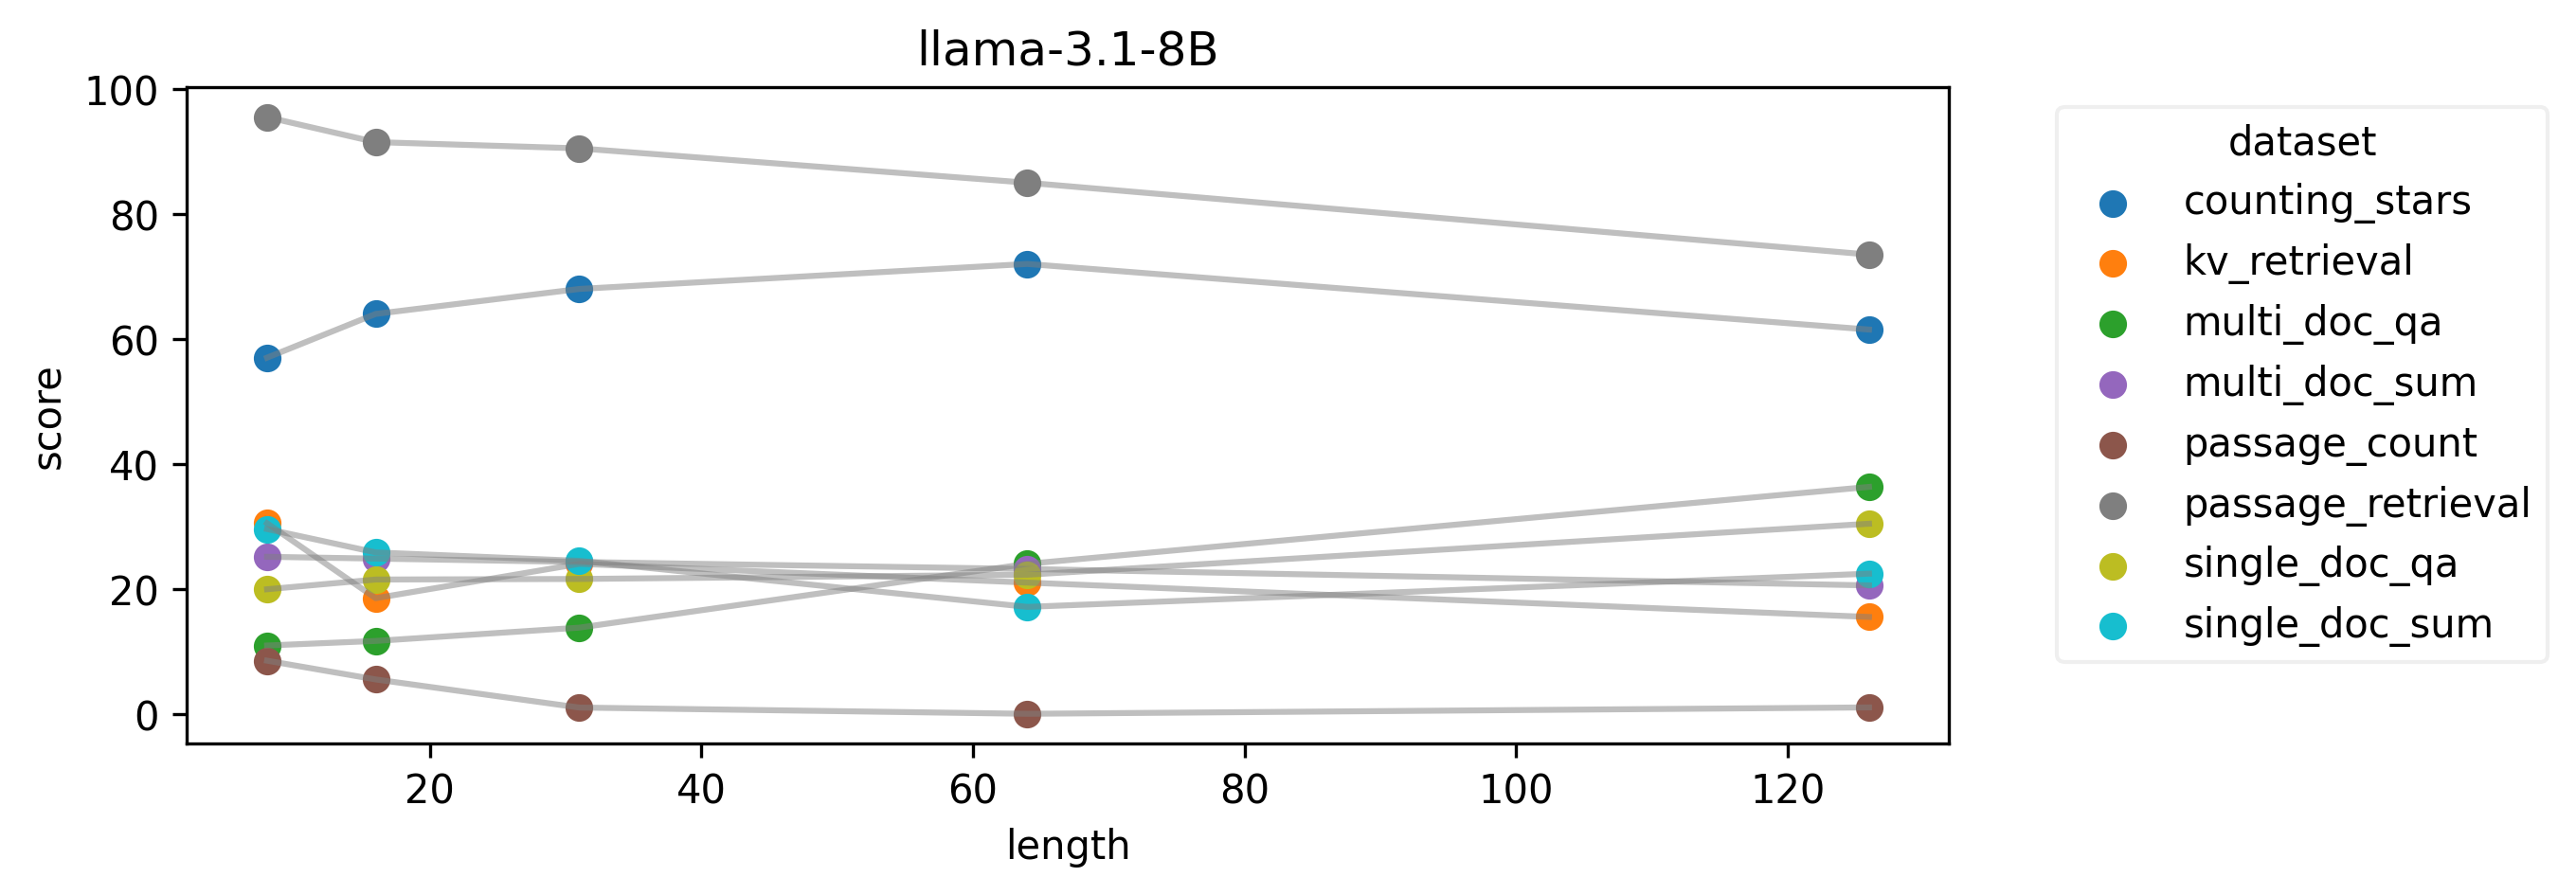

{'counting_stars': [(126, 61.5), (16, 64.0), (31, 68.0), (64, 72.0), (8, 57.0)], 'kv_retrieval': [(126, 15.5), (16, 18.5), (31, 24.0), (64, 21.0), (8, 30.5)], 'multi_doc_qa': [(126, 36.32), (16, 11.66), (31, 13.79), (64, 24.0), (8, 10.93)], 'multi_doc_sum': [(126, 20.55), (16, 24.84), (31, 24.3), (64, 23.18), (8, 25.13)], 'passage_count': [(126, 1.02), (16, 5.5), (31, 1.0), (64, 0.0), (8, 8.5)], 'passage_retrieval': [(126, 73.5), (16, 91.5), (31, 90.5), (64, 85.0), (8, 95.5)], 'single_doc_qa': [(126, 30.42), (16, 21.49), (31, 21.58), (64, 22.26), (8, 19.93)], 'single_doc_sum': [(126, 22.43), (16, 25.83), (31, 24.48), (64, 17.11), (8, 29.57)]}


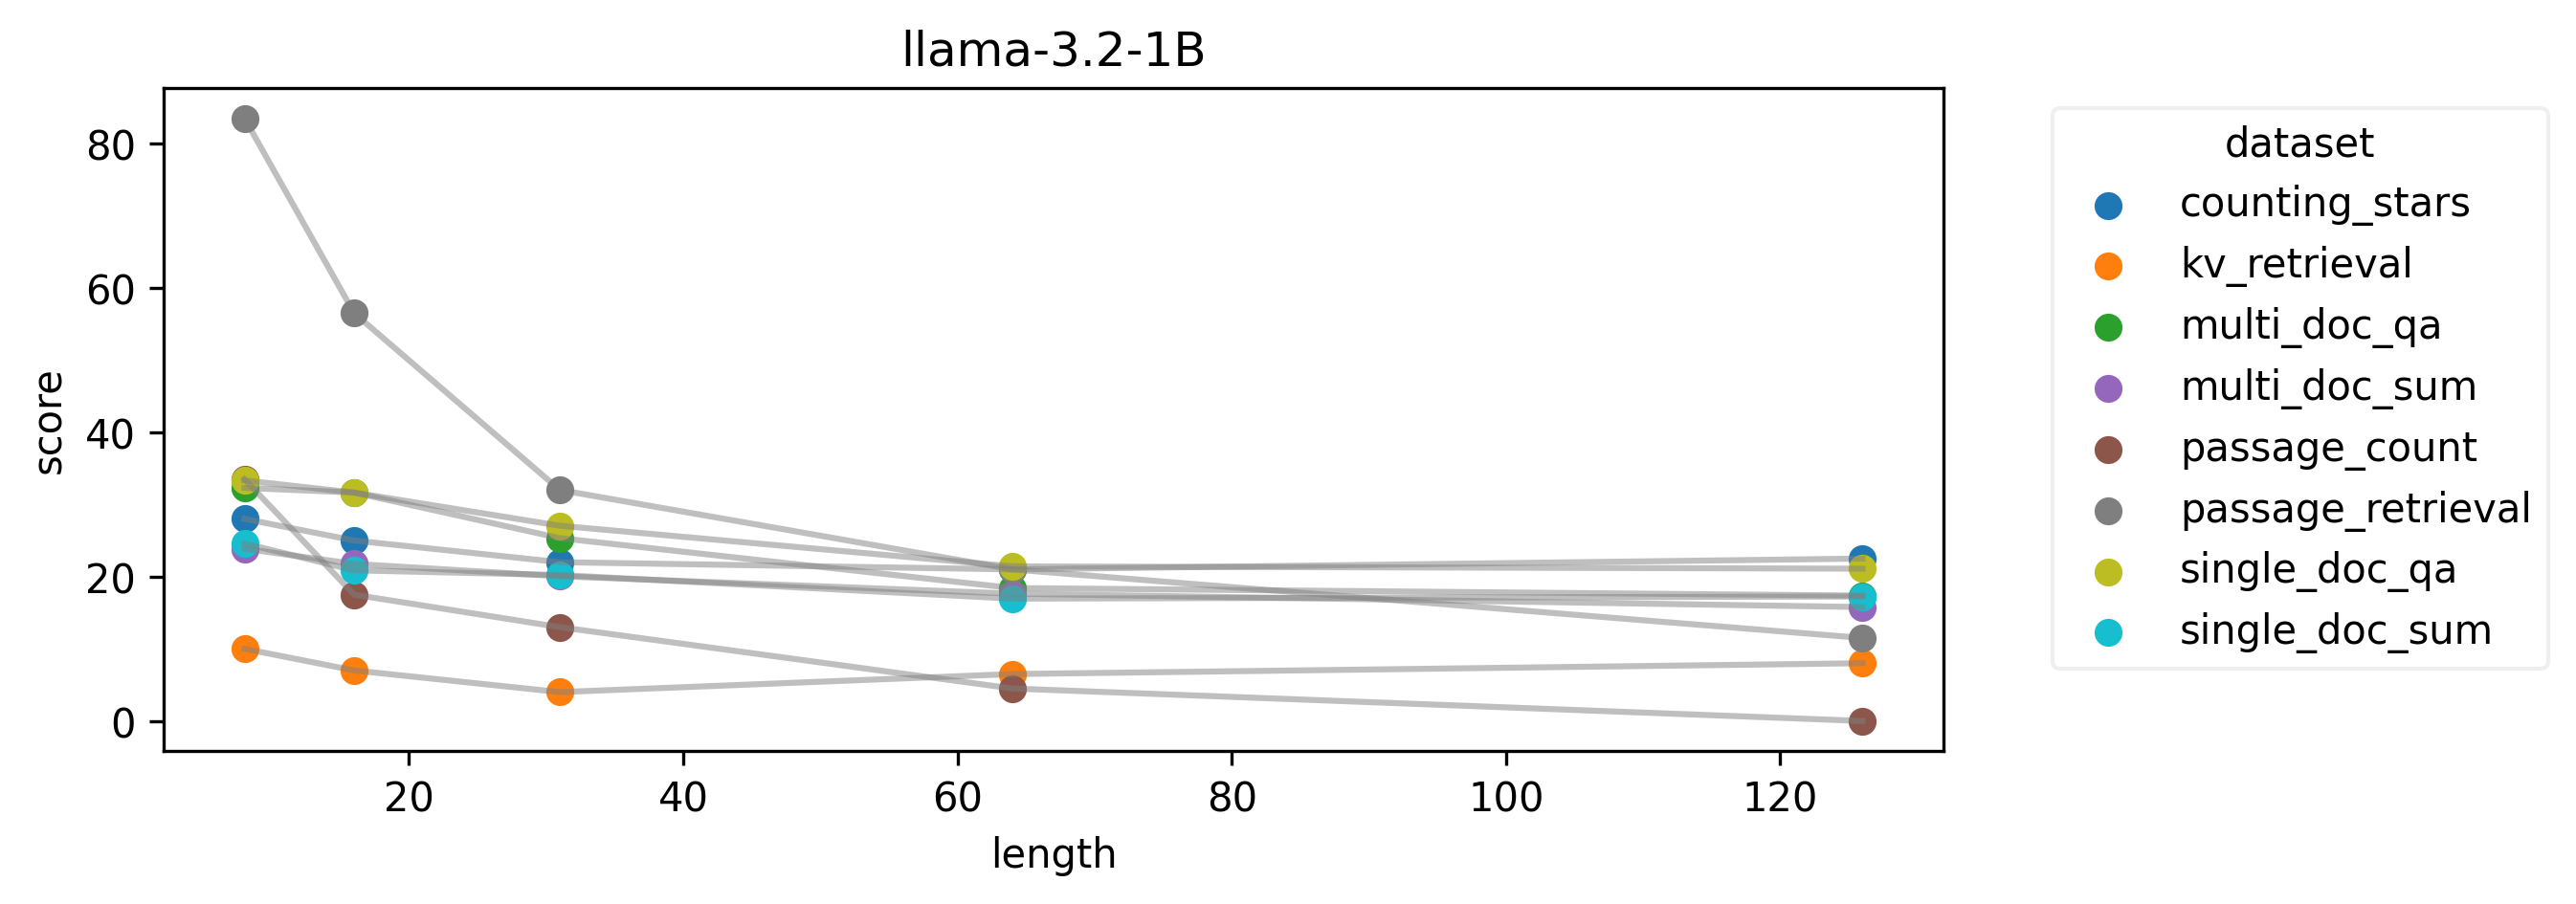

{'counting_stars': [(126, 22.5), (16, 25.0), (31, 22.0), (64, 21.0), (8, 28.0)], 'kv_retrieval': [(126, 8.0), (16, 7.0), (31, 4.0), (64, 6.5), (8, 10.0)], 'multi_doc_qa': [(126, 17.37), (16, 31.65), (31, 25.33), (64, 18.42), (8, 32.29)], 'multi_doc_sum': [(126, 15.78), (16, 21.76), (31, 20.05), (64, 17.64), (8, 23.86)], 'passage_count': [(126, 0.0), (16, 17.5), (31, 13.0), (64, 4.5), (8, 33.5)], 'passage_retrieval': [(126, 11.5), (16, 56.5), (31, 32.0), (64, 21.0), (8, 83.5)], 'single_doc_qa': [(126, 21.1), (16, 31.64), (31, 27.05), (64, 21.42), (8, 33.33)], 'single_doc_sum': [(126, 17.25), (16, 20.87), (31, 20.22), (64, 16.95), (8, 24.6)]}


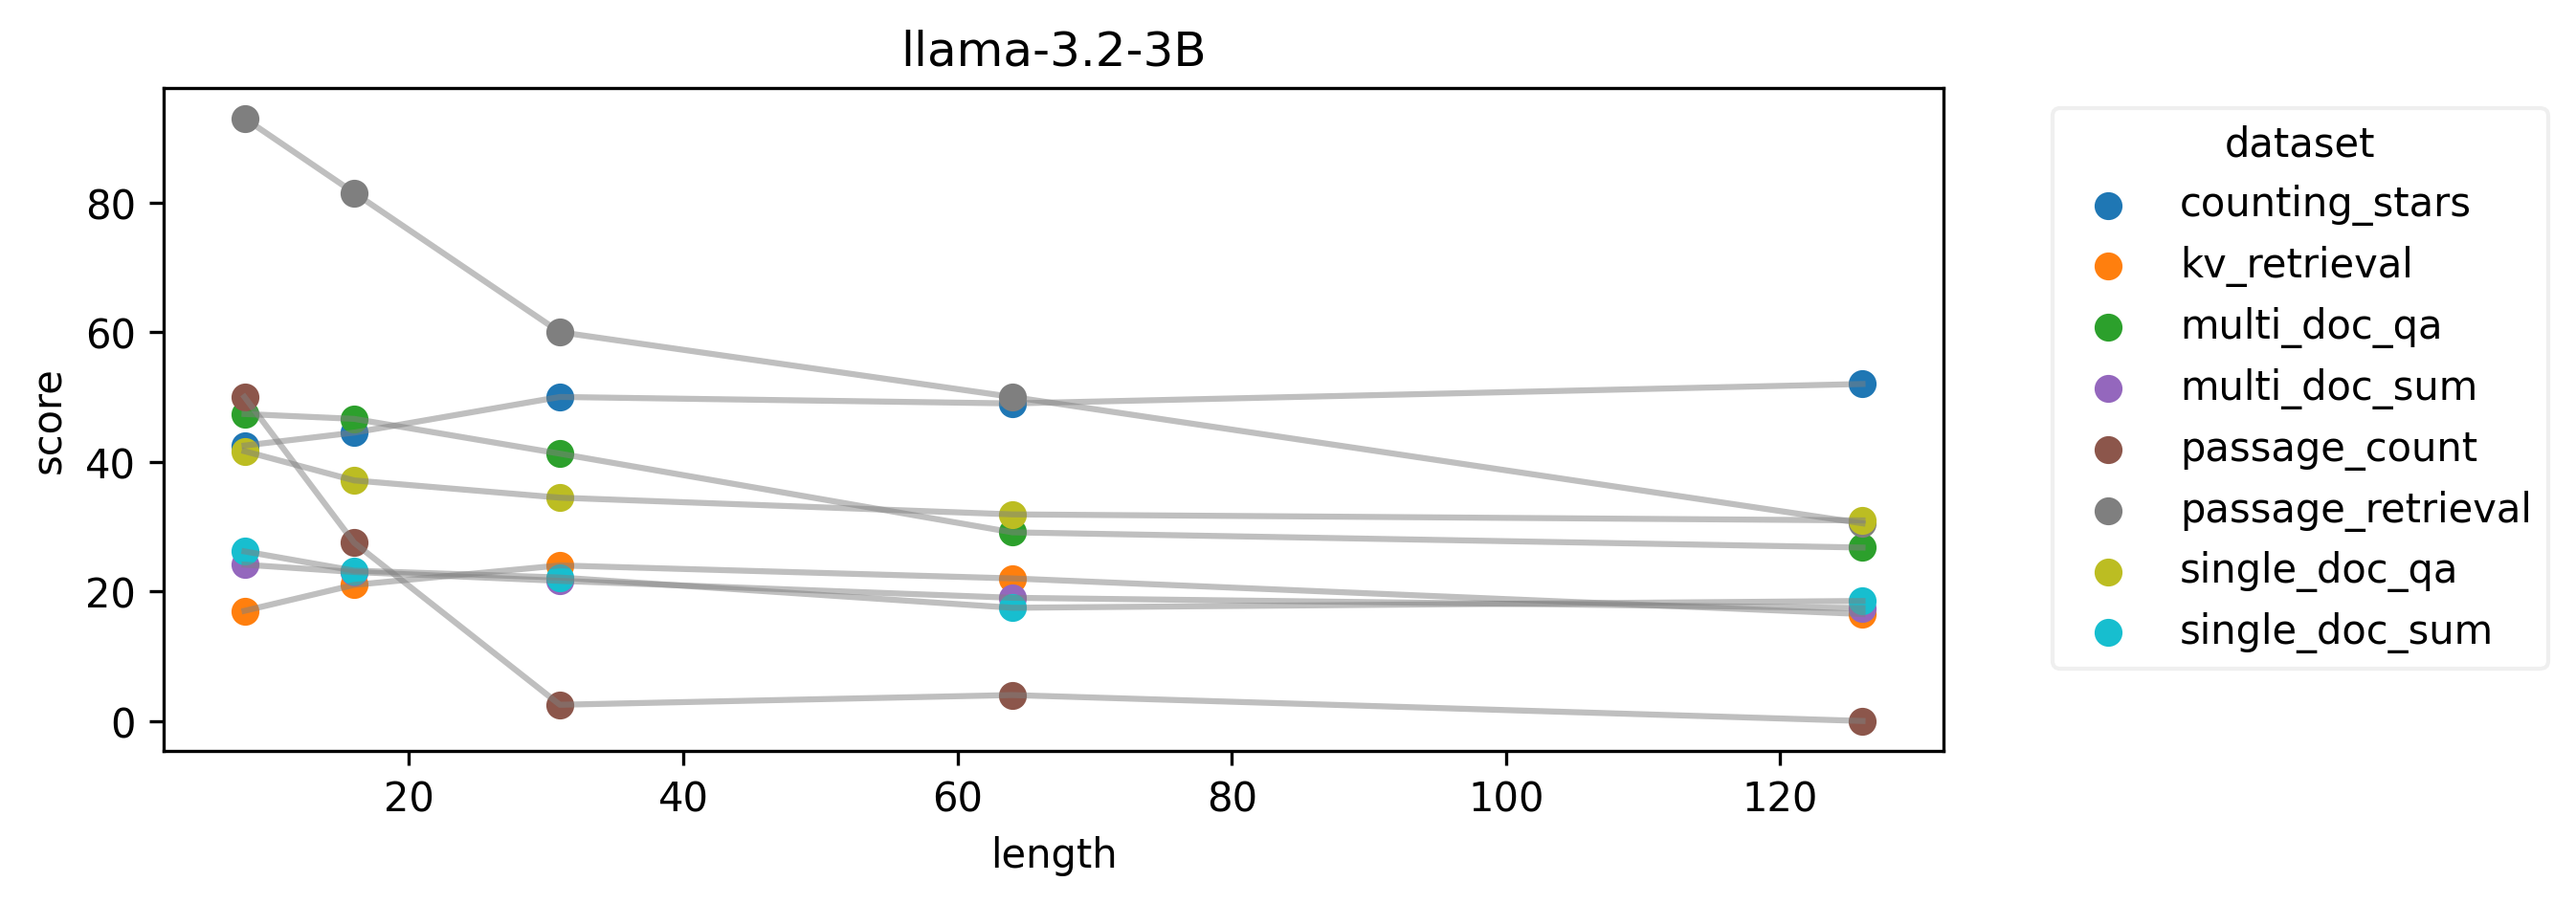

{'counting_stars': [(126, 52.0), (16, 44.5), (31, 50.0), (64, 49.0), (8, 42.5)], 'kv_retrieval': [(126, 16.5), (16, 21.0), (31, 24.0), (64, 22.0), (8, 17.0)], 'multi_doc_qa': [(126, 26.76), (16, 46.62), (31, 41.25), (64, 29.11), (8, 47.37)], 'multi_doc_sum': [(126, 17.42), (16, 22.99), (31, 21.62), (64, 19.01), (8, 24.12)], 'passage_count': [(126, 0.0), (16, 27.5), (31, 2.5), (64, 4.0), (8, 50.0)], 'passage_retrieval': [(126, 30.5), (16, 81.5), (31, 60.0), (64, 50.0), (8, 93.0)], 'single_doc_qa': [(126, 30.95), (16, 37.12), (31, 34.46), (64, 31.88), (8, 41.63)], 'single_doc_sum': [(126, 18.52), (16, 23.2), (31, 22.14), (64, 17.47), (8, 26.17)]}


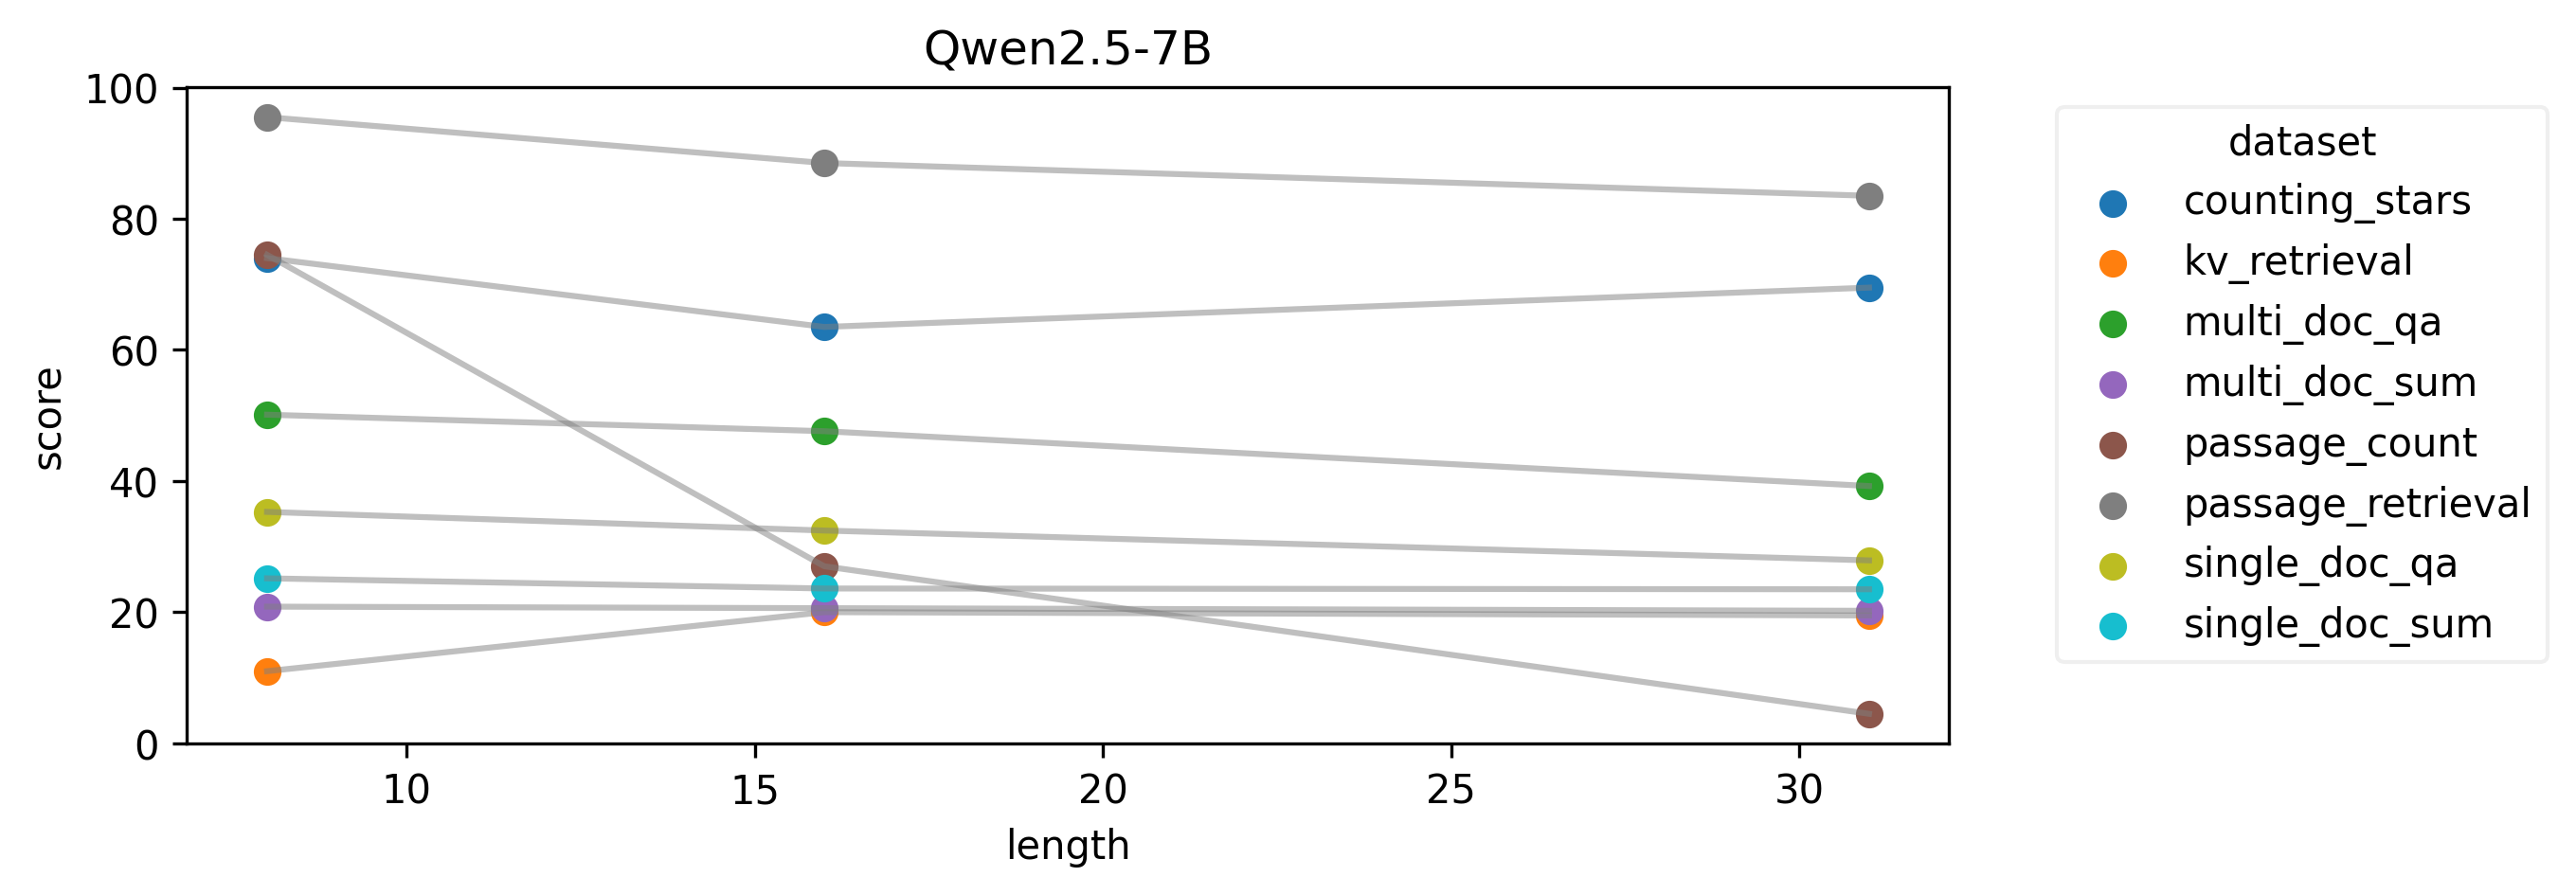

{'counting_stars': [(16, 63.5), (31, 69.5), (8, 74.0)], 'kv_retrieval': [(16, 20.0), (31, 19.5), (8, 11.0)], 'multi_doc_qa': [(16, 47.6), (31, 39.24), (8, 50.12)], 'multi_doc_sum': [(16, 20.61), (31, 20.21), (8, 20.84)], 'passage_count': [(16, 27.0), (31, 4.5), (8, 74.5)], 'passage_retrieval': [(16, 88.5), (31, 83.5), (8, 95.5)], 'single_doc_qa': [(16, 32.45), (31, 27.9), (8, 35.29)], 'single_doc_sum': [(16, 23.61), (31, 23.49), (8, 25.16)]}


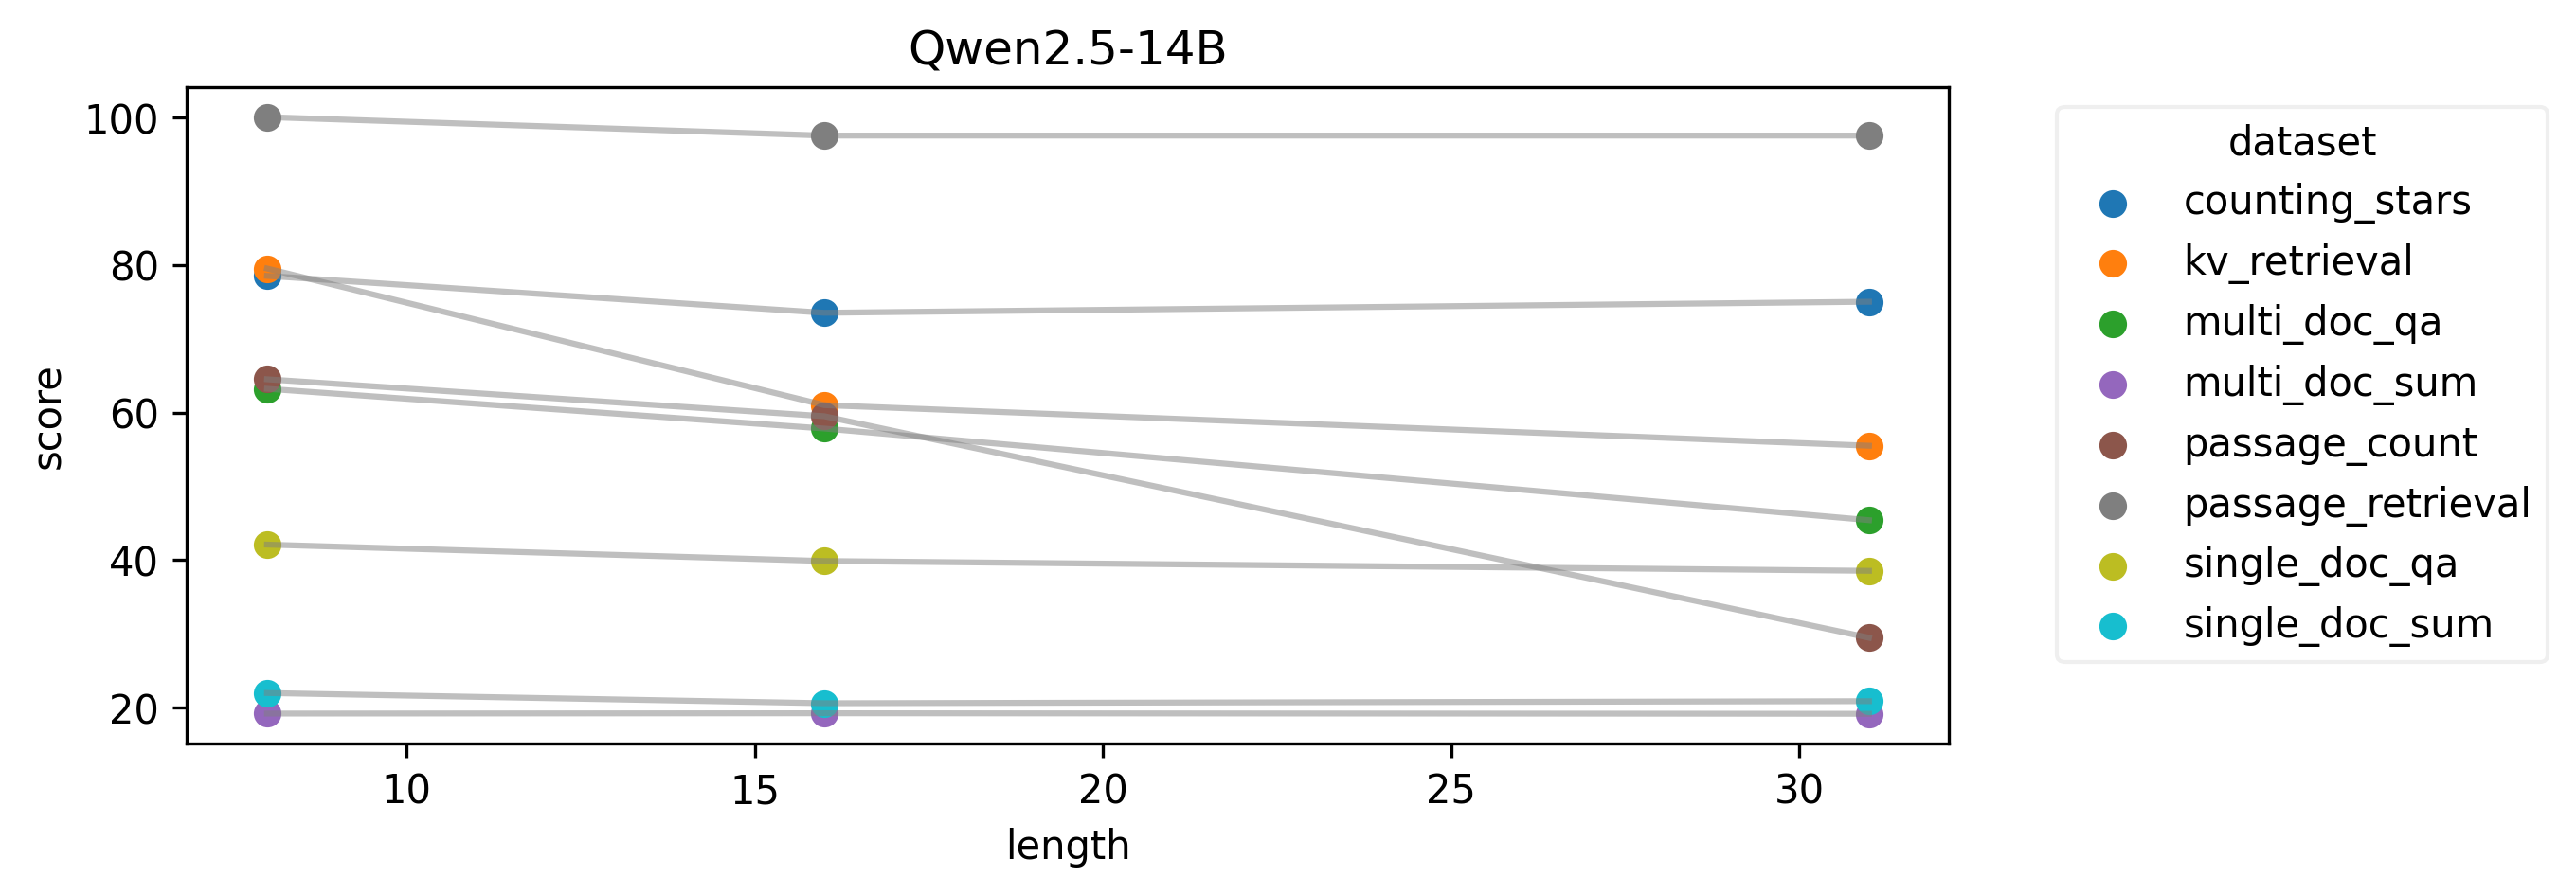

{'counting_stars': [(16, 73.5), (31, 75.0), (8, 78.5)], 'kv_retrieval': [(16, 61.0), (31, 55.5), (8, 79.5)], 'multi_doc_qa': [(16, 57.83), (31, 45.42), (8, 63.21)], 'multi_doc_sum': [(16, 19.27), (31, 19.2), (8, 19.23)], 'passage_count': [(16, 59.5), (31, 29.5), (8, 64.5)], 'passage_retrieval': [(16, 97.5), (31, 97.5), (8, 100.0)], 'single_doc_qa': [(16, 39.89), (31, 38.56), (8, 42.11)], 'single_doc_sum': [(16, 20.63), (31, 20.91), (8, 22.01)]}


In [3]:
from collections import defaultdict
for model in results.keys():
    draw_things = defaultdict(list)
    for dataset,score in results[model].items():
        name = dataset.split('_')
        name, x = '_'.join(name[:-1]), int(name[-1])
        draw_things[name].append((x, score))
    draw_things = {key: draw_things[key] for key in sorted(draw_things)}
    # 为每种类型生成不同的颜色
    plt.figure(figsize=(8, 3), dpi=300)
    colors = plt.cm.get_cmap('tab10', len(draw_things.keys()))
    for i, (dataset,scores) in enumerate(draw_things.items()):
        scores = sorted(scores, key=lambda x: x[0])
        x, y = [s_i[0] for s_i in scores], [s_i[1] for s_i in scores]
        # 创建折线图
        plt.plot(x, y, linestyle='-', color='gray', alpha=0.5)  # 绘制灰色折线
        # 绘制每个点，并根据类型分配颜色
        plt.scatter(x, y, color=colors(i), label=dataset)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="dataset", framealpha=0.3)
    plt.title(model)
    plt.xlabel("length")
    plt.ylabel("score")
    plt.show()
    print(draw_things)


In [3]:
path = {
        'ntk':'/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-slimpajama-ntk-32k', 
        'pi': '/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-slimpajama-pi-32k',
        'lminfinite': '/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-lminfinite',
        'longlora': '/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-slimpajama-longlora-32k',
        'yarn': '/users/PDS0352/wyang107/project/LCEG/longbench/pred/llama2-7b-hf-slimpajama-yarn-32k',
        }
results, results_all = dict(), dict()
for model, p in path.items():
    results[model]= json.load(open(os.path.join(p,'result.json'), 'r'))
    results_all[model]= json.load(open(os.path.join(p,'result_all.json'), 'r'))


In [4]:
from collections import defaultdict
x_map = {'0-2k':2, '2-4k':4, '4-6k':6, '6-8k':8, '8k+':10}
dataset_re = defaultdict(dict)
for model, result in results.items():
    for dataset in result.keys():
        # print(model, dataset, result[dataset])
        for x, res in result[dataset].items():
            if model not in dataset_re[dataset]:
                dataset_re[dataset][model]=[(x_map[x], res['score'], res['num'])]
            else:
                dataset_re[dataset][model].append((x_map[x], res['score'], res['num']))
print(dataset_re['qasper'])
print(results_all)

{'ntk': [(2, 0, 0), (4, 35.51, 53), (6, 26.43, 69), (8, 28.64, 55), (10, 23.96, 23)], 'pi': [(2, 0, 0), (4, 28.78, 53), (6, 26.0, 69), (8, 24.57, 55), (10, 25.86, 23)], 'lminfinite': [(2, 0, 0), (4, 32.92, 53), (6, 17.51, 69), (8, 25.34, 55), (10, 8.37, 23)], 'longlora': [(2, 0, 0), (4, 19.23, 53), (6, 20.68, 69), (8, 22.29, 55), (10, 17.53, 23)], 'yarn': [(2, 0, 0), (4, 32.42, 53), (6, 26.65, 69), (8, 25.93, 55), (10, 15.54, 23)]}
{'ntk': {'qasper': 29.16, 'multifieldqa_en': 37.25, 'hotpotqa': 40.03, '2wikimqa': 31.11, 'musique': 17.11, 'gov_report': 27.83, 'qmsum': 22.37, 'multi_news': 22.82, 'trec': 68.0, 'triviaqa': 89.19, 'samsum': 42.57, 'passage_count': 2.55, 'passage_retrieval_en': 5.62, 'lcc': 54.52, 'repobench-p': 46.35, 'narrativeqa': 23.21}, 'pi': {'qasper': 26.33, 'multifieldqa_en': 35.07, 'hotpotqa': 36.98, '2wikimqa': 29.38, 'musique': 17.2, 'gov_report': 25.46, 'qmsum': 21.34, 'multi_news': 10.45, 'trec': 71.0, 'triviaqa': 88.55, 'samsum': 43.28, 'passage_count': 1.5, '

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


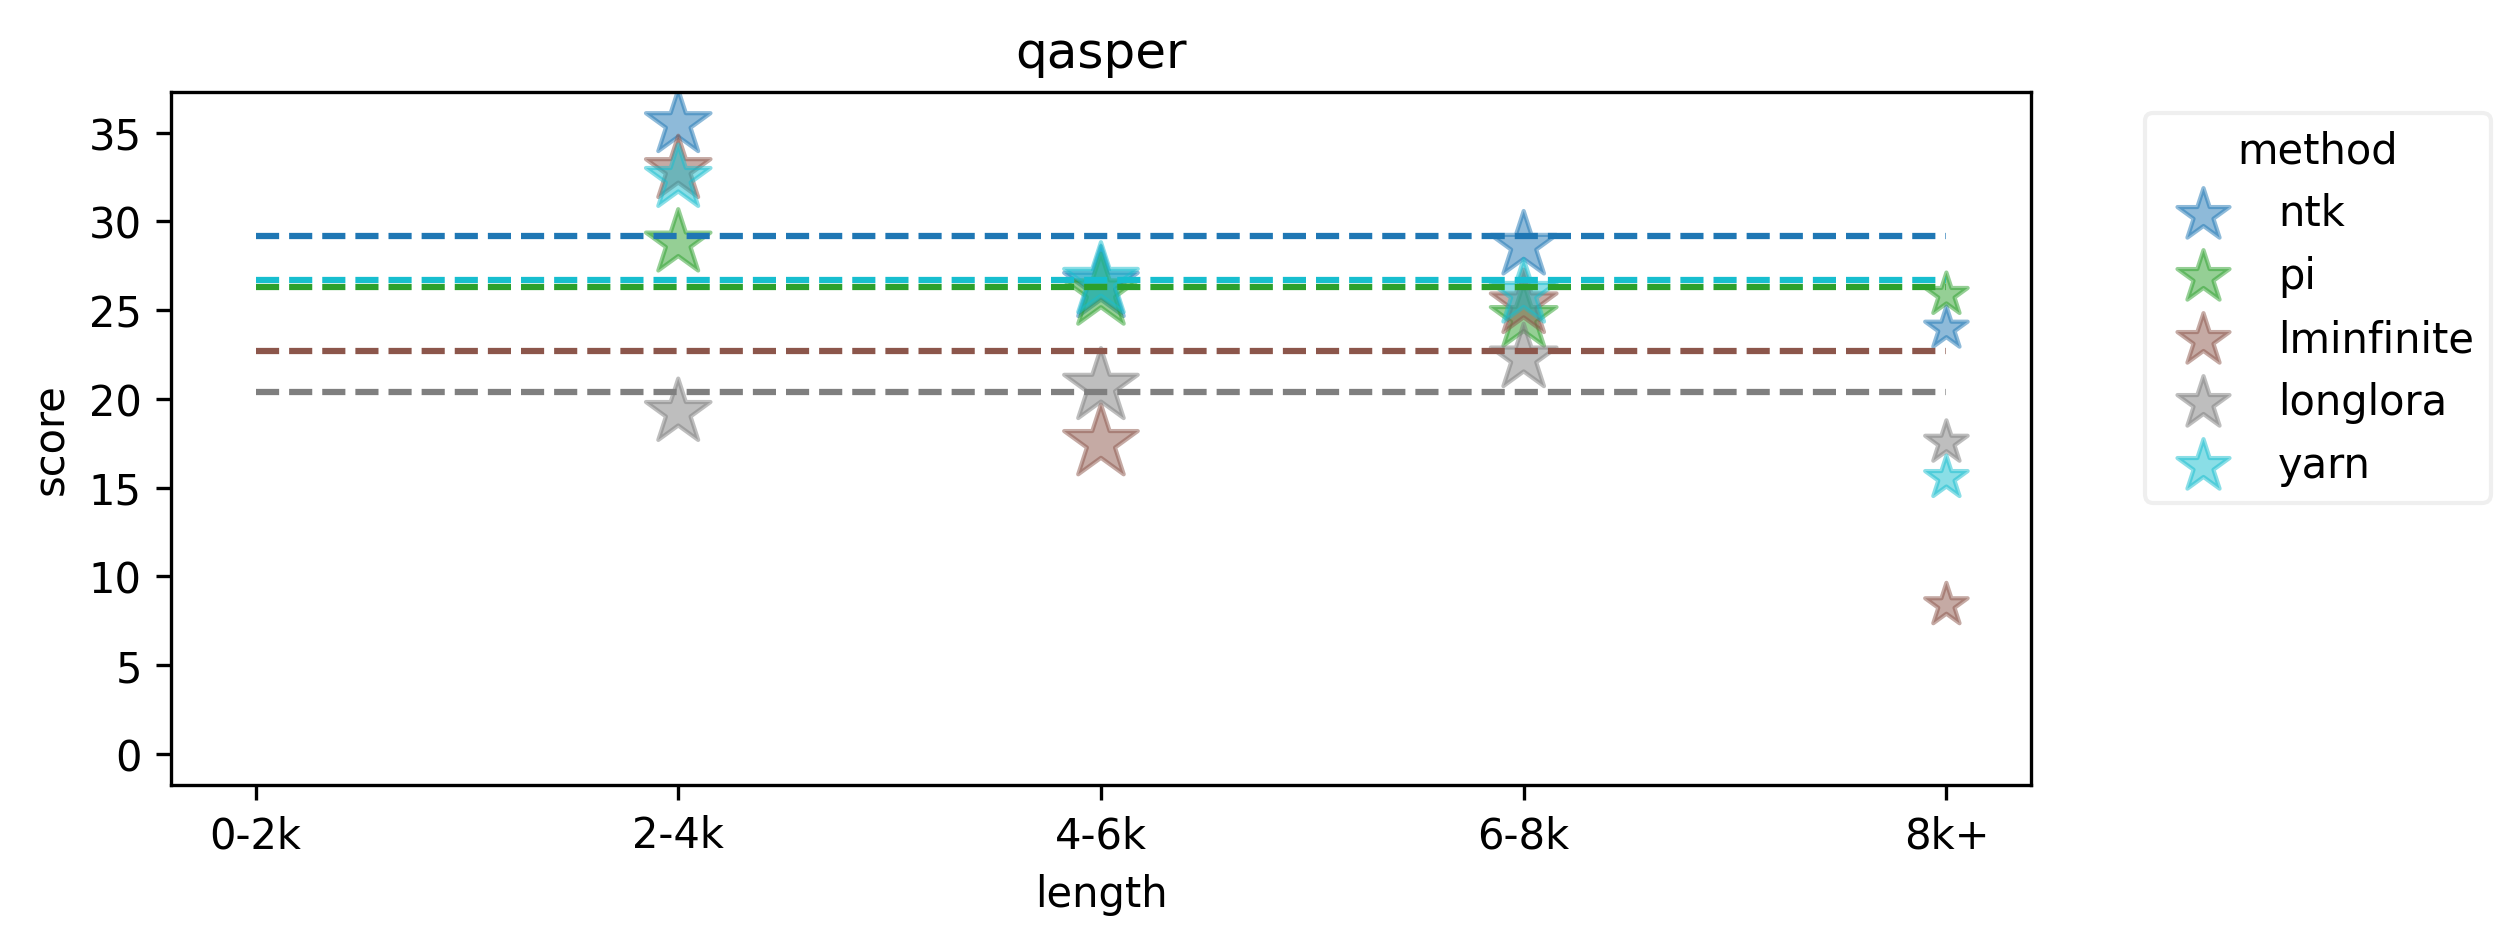

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


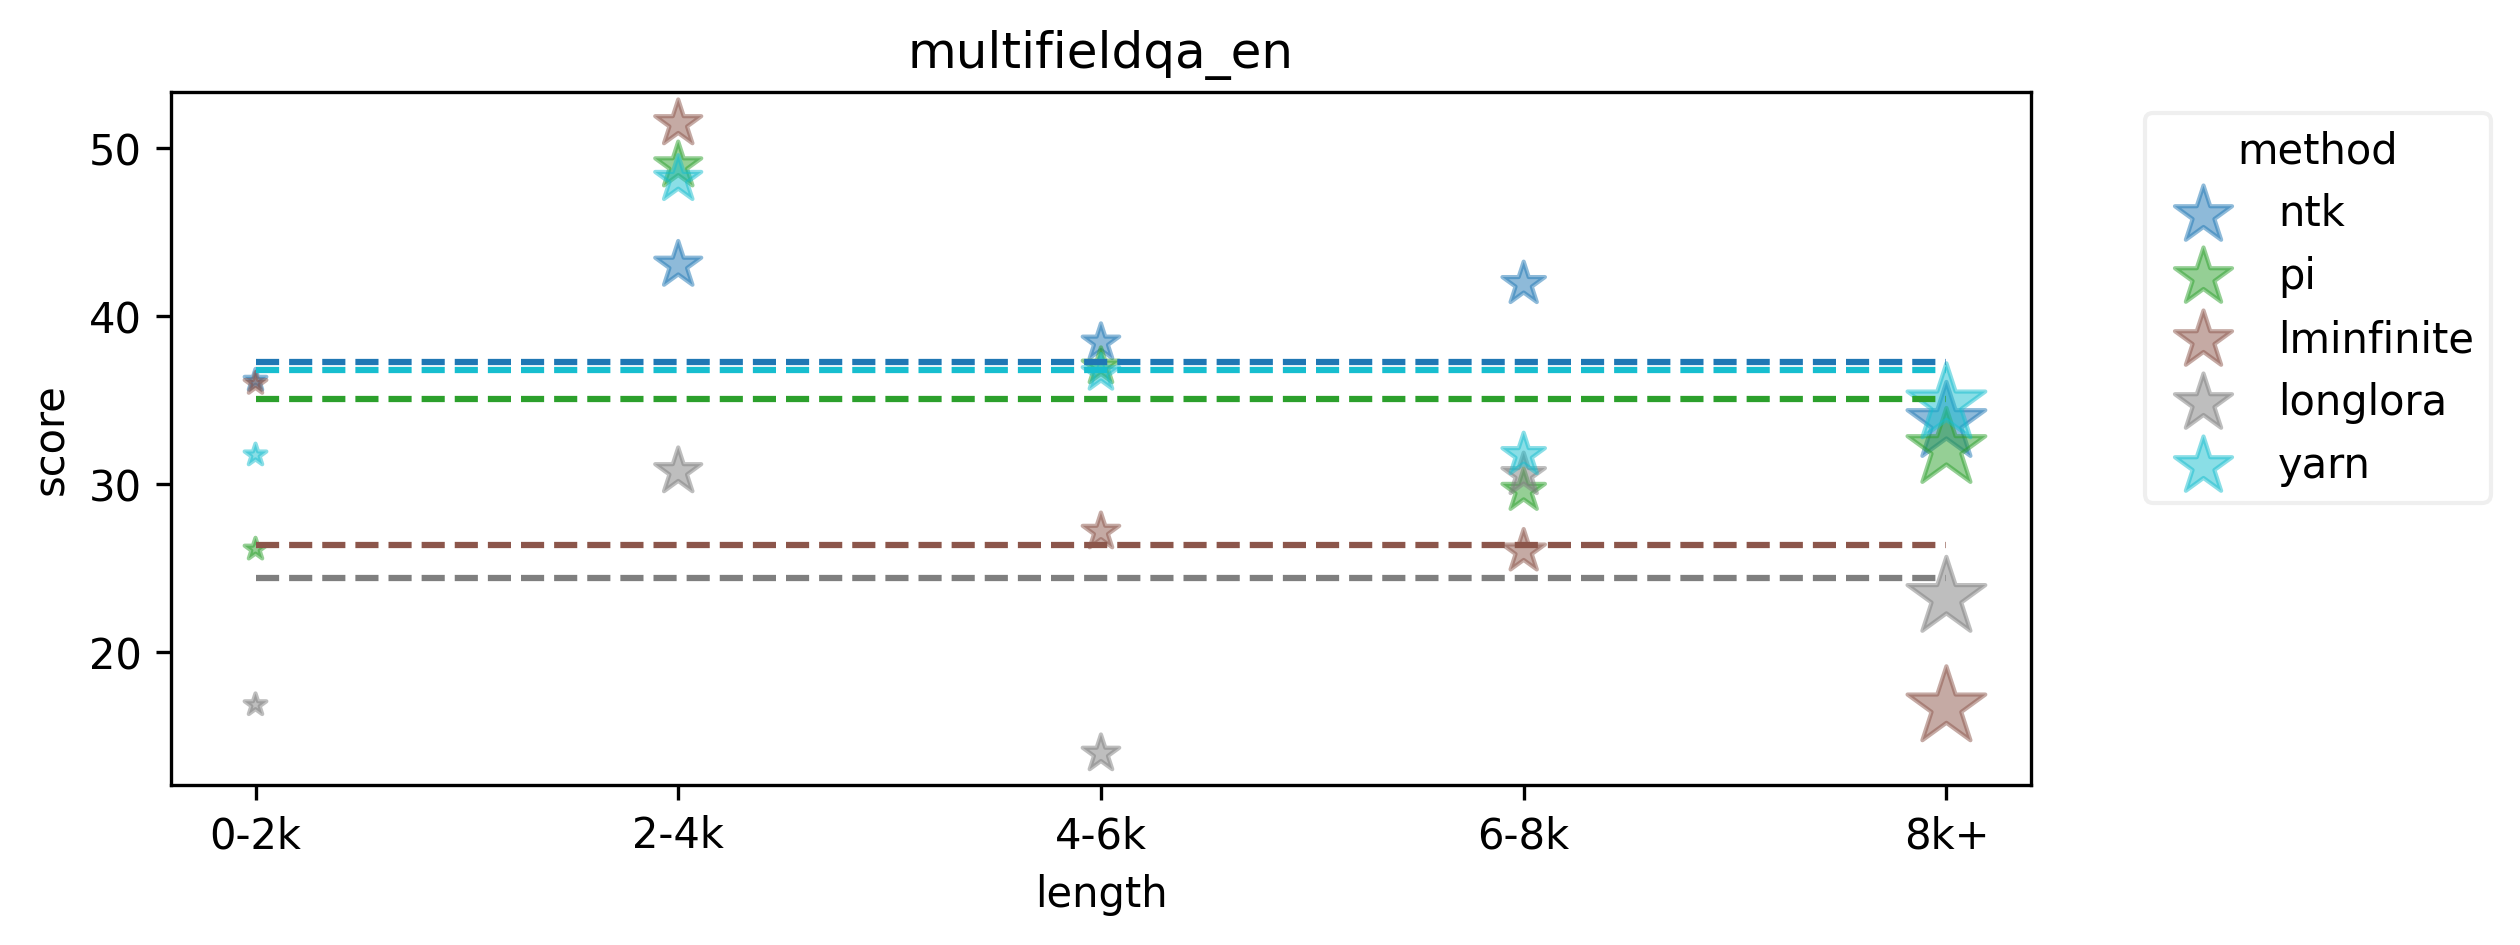

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


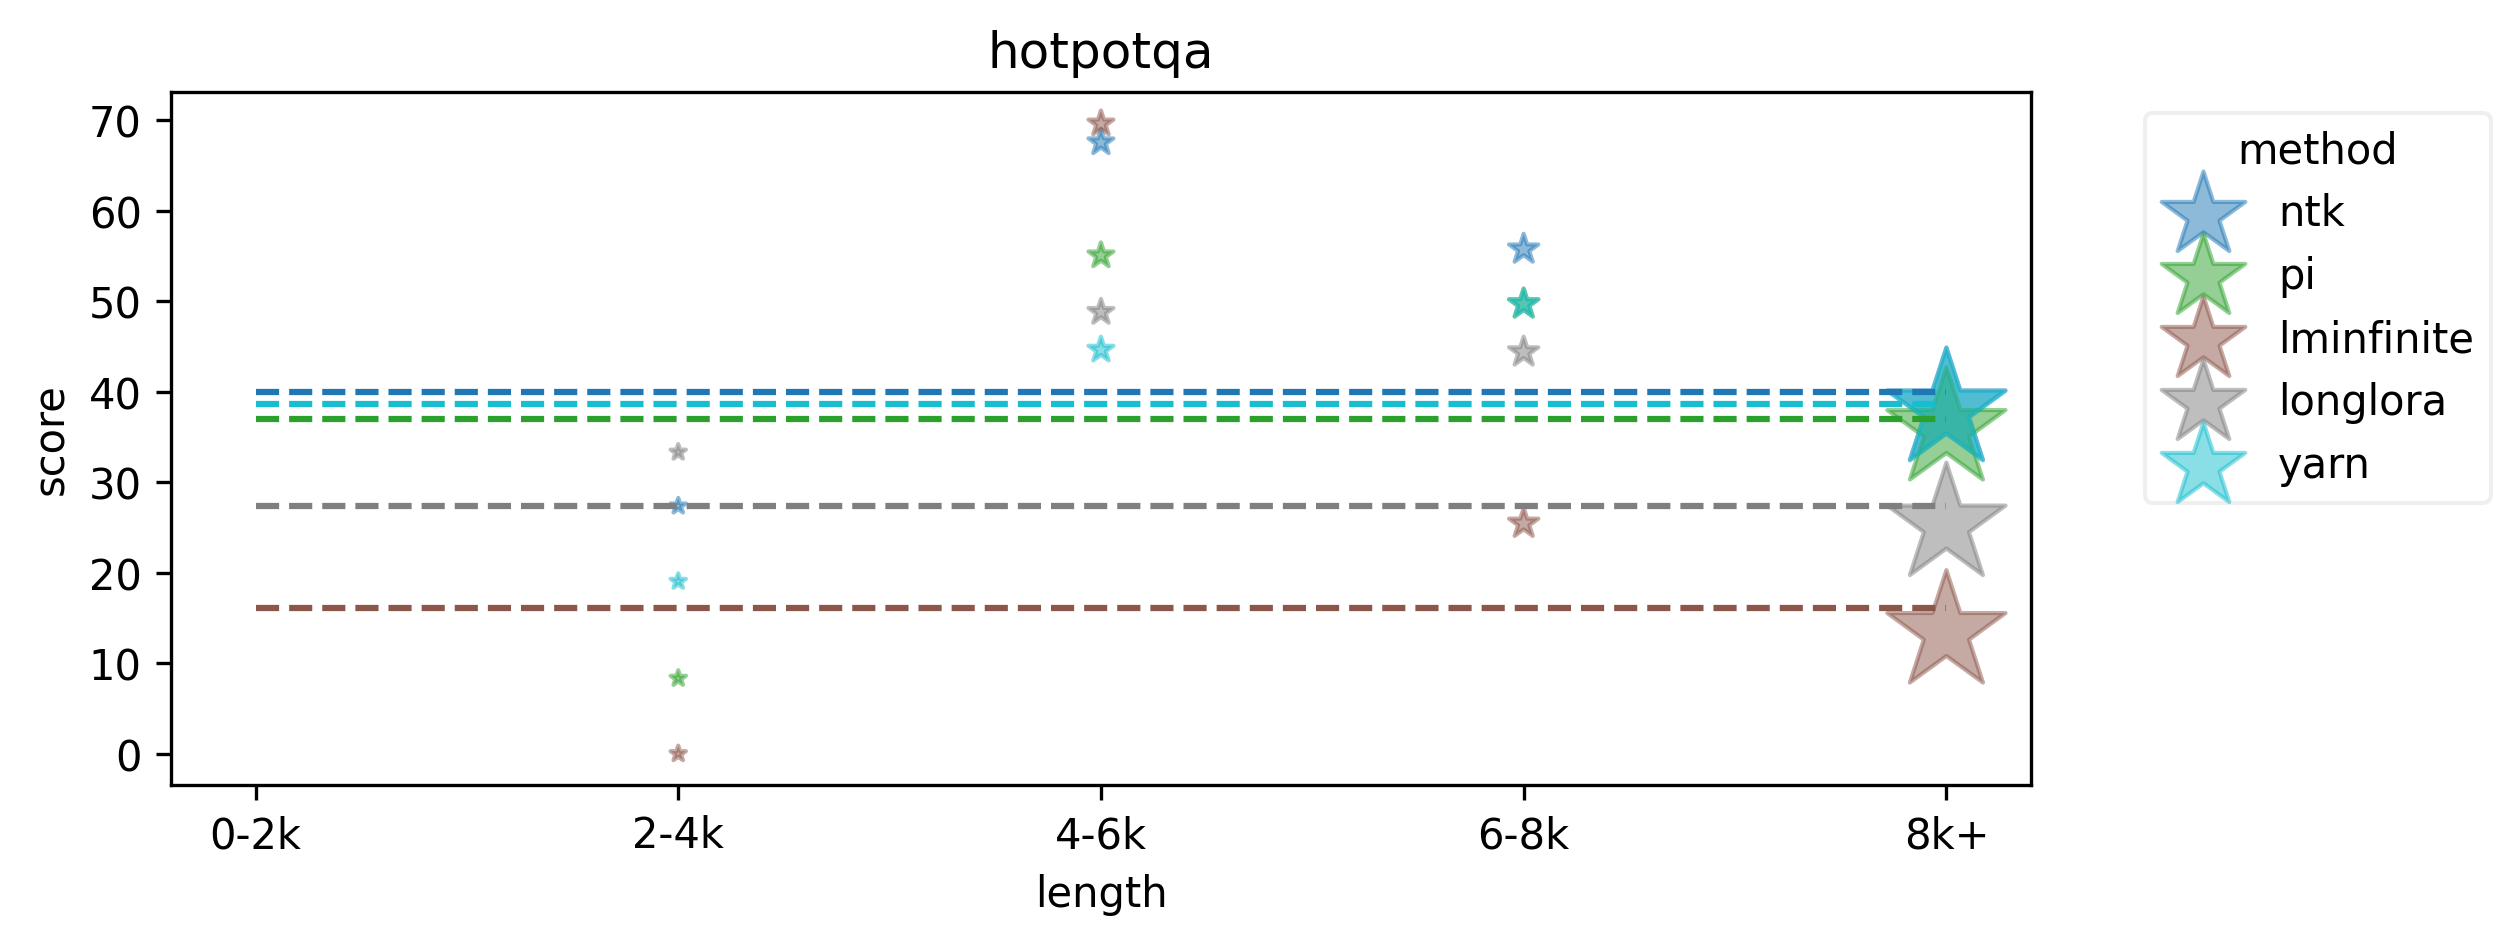

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


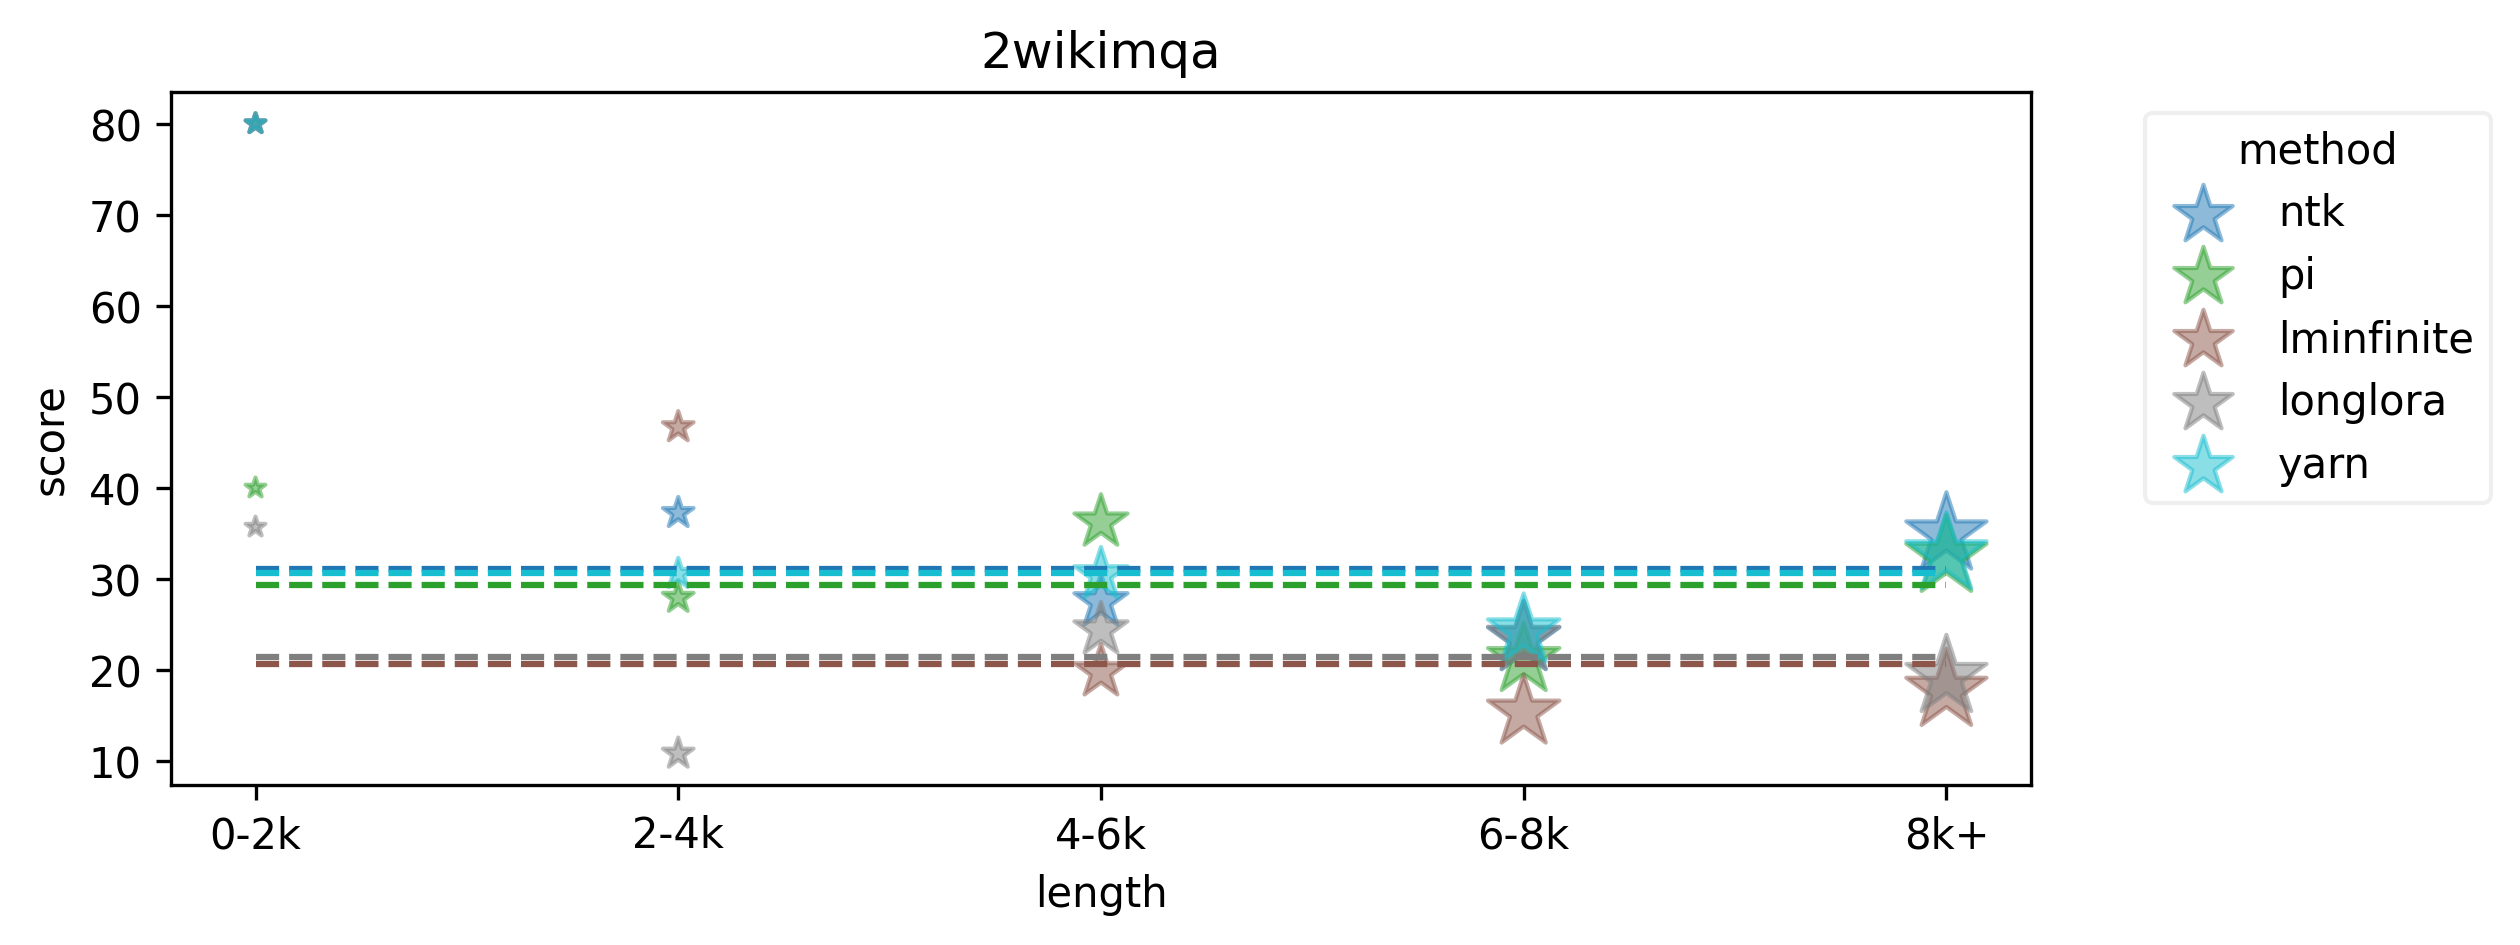

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


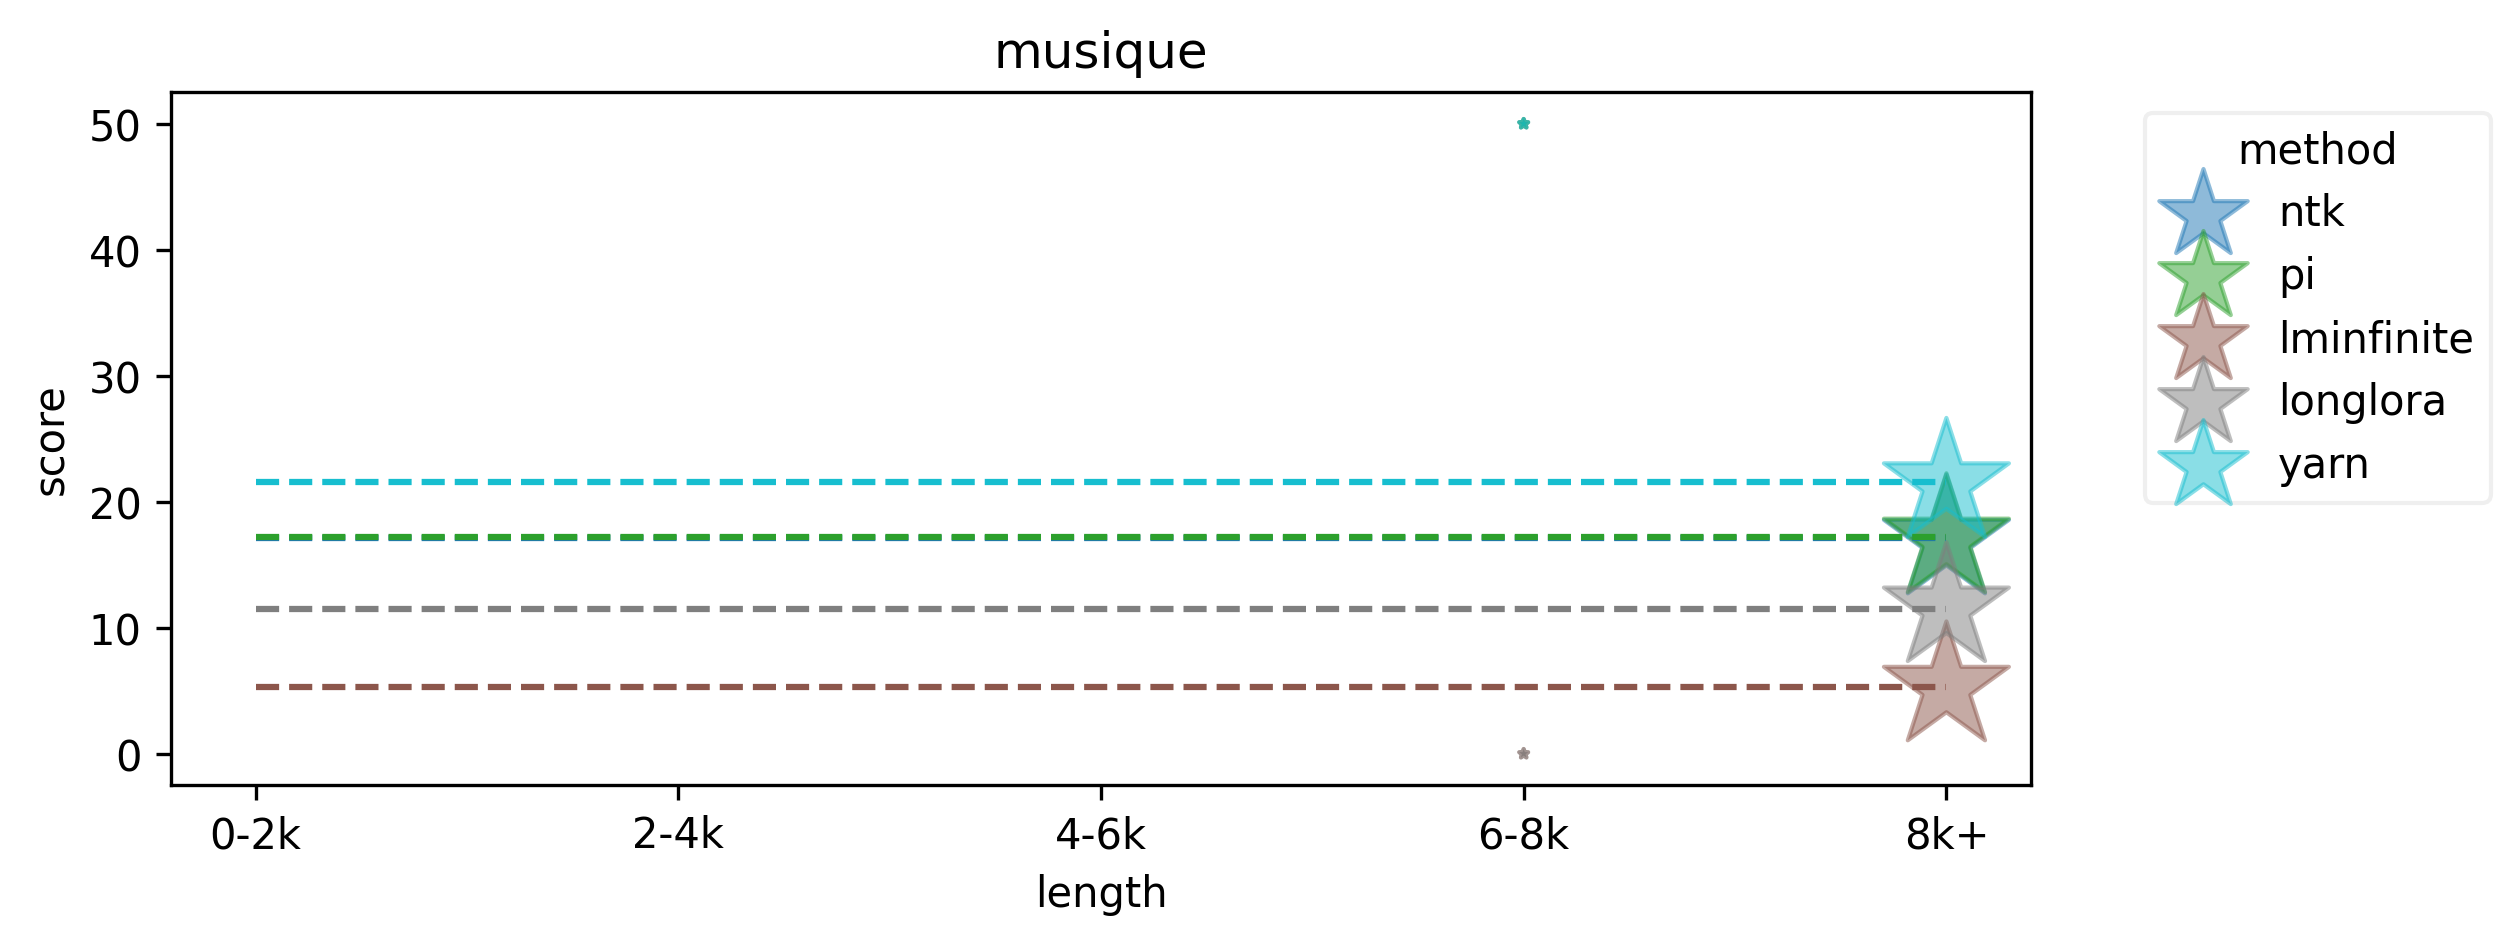

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


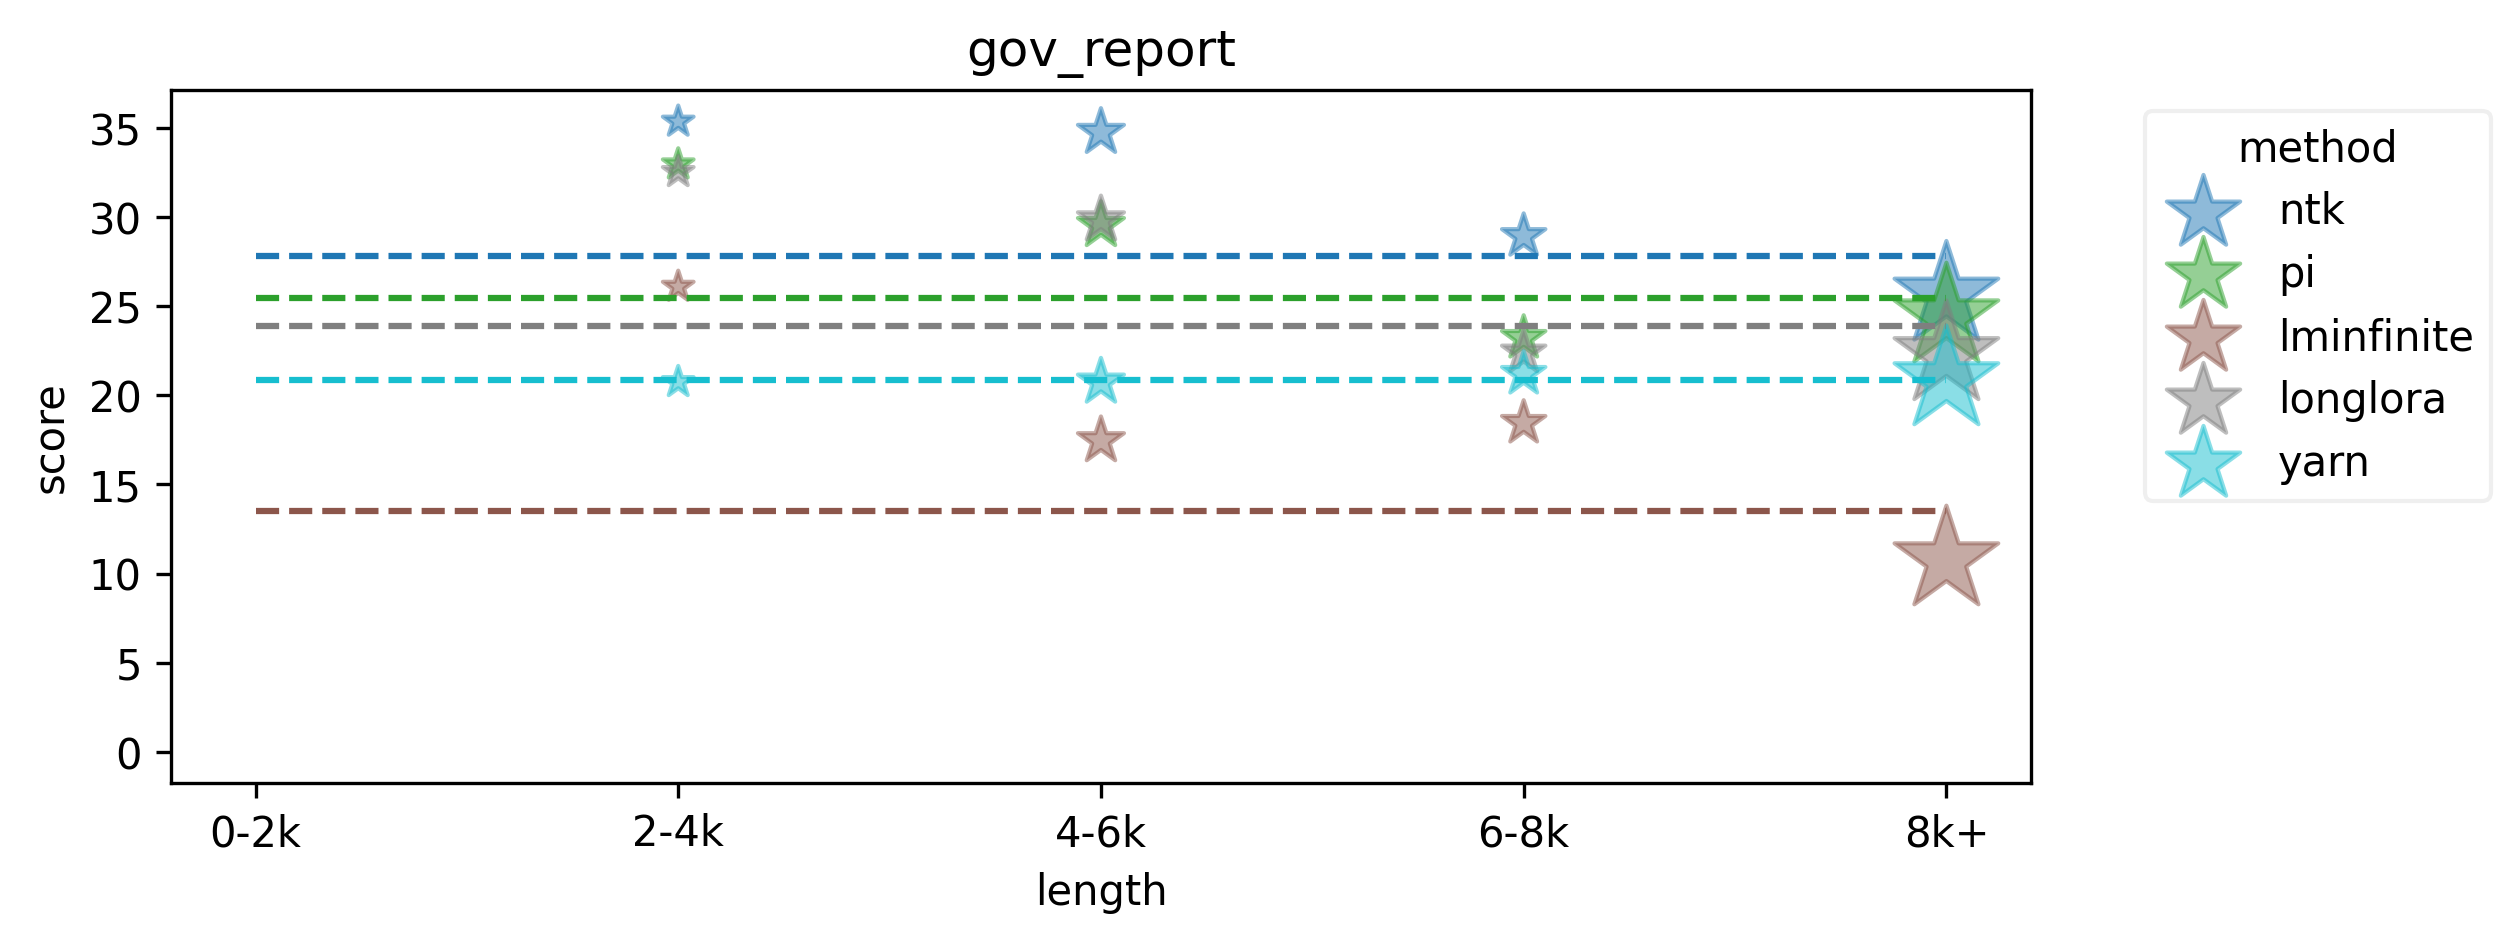

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


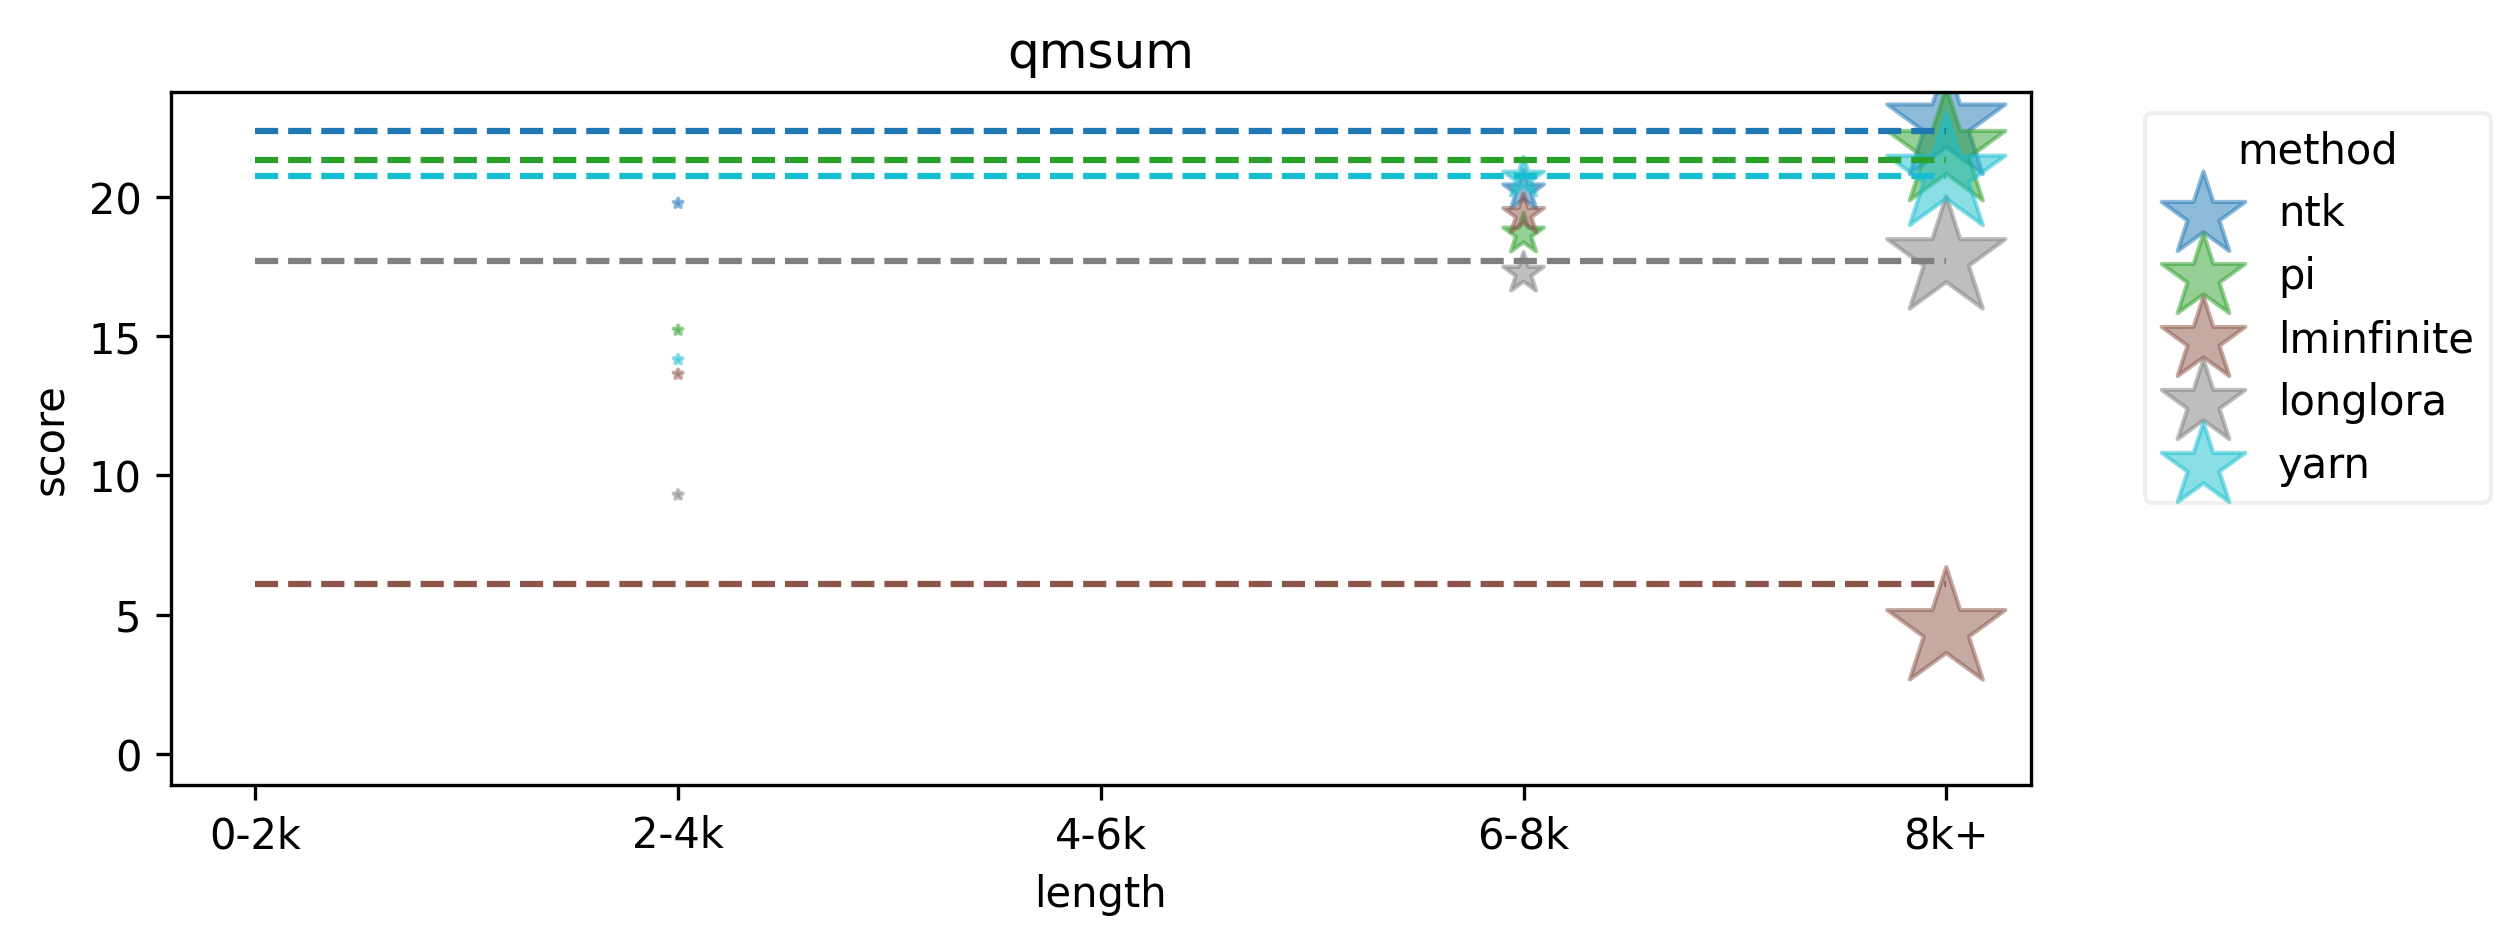

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


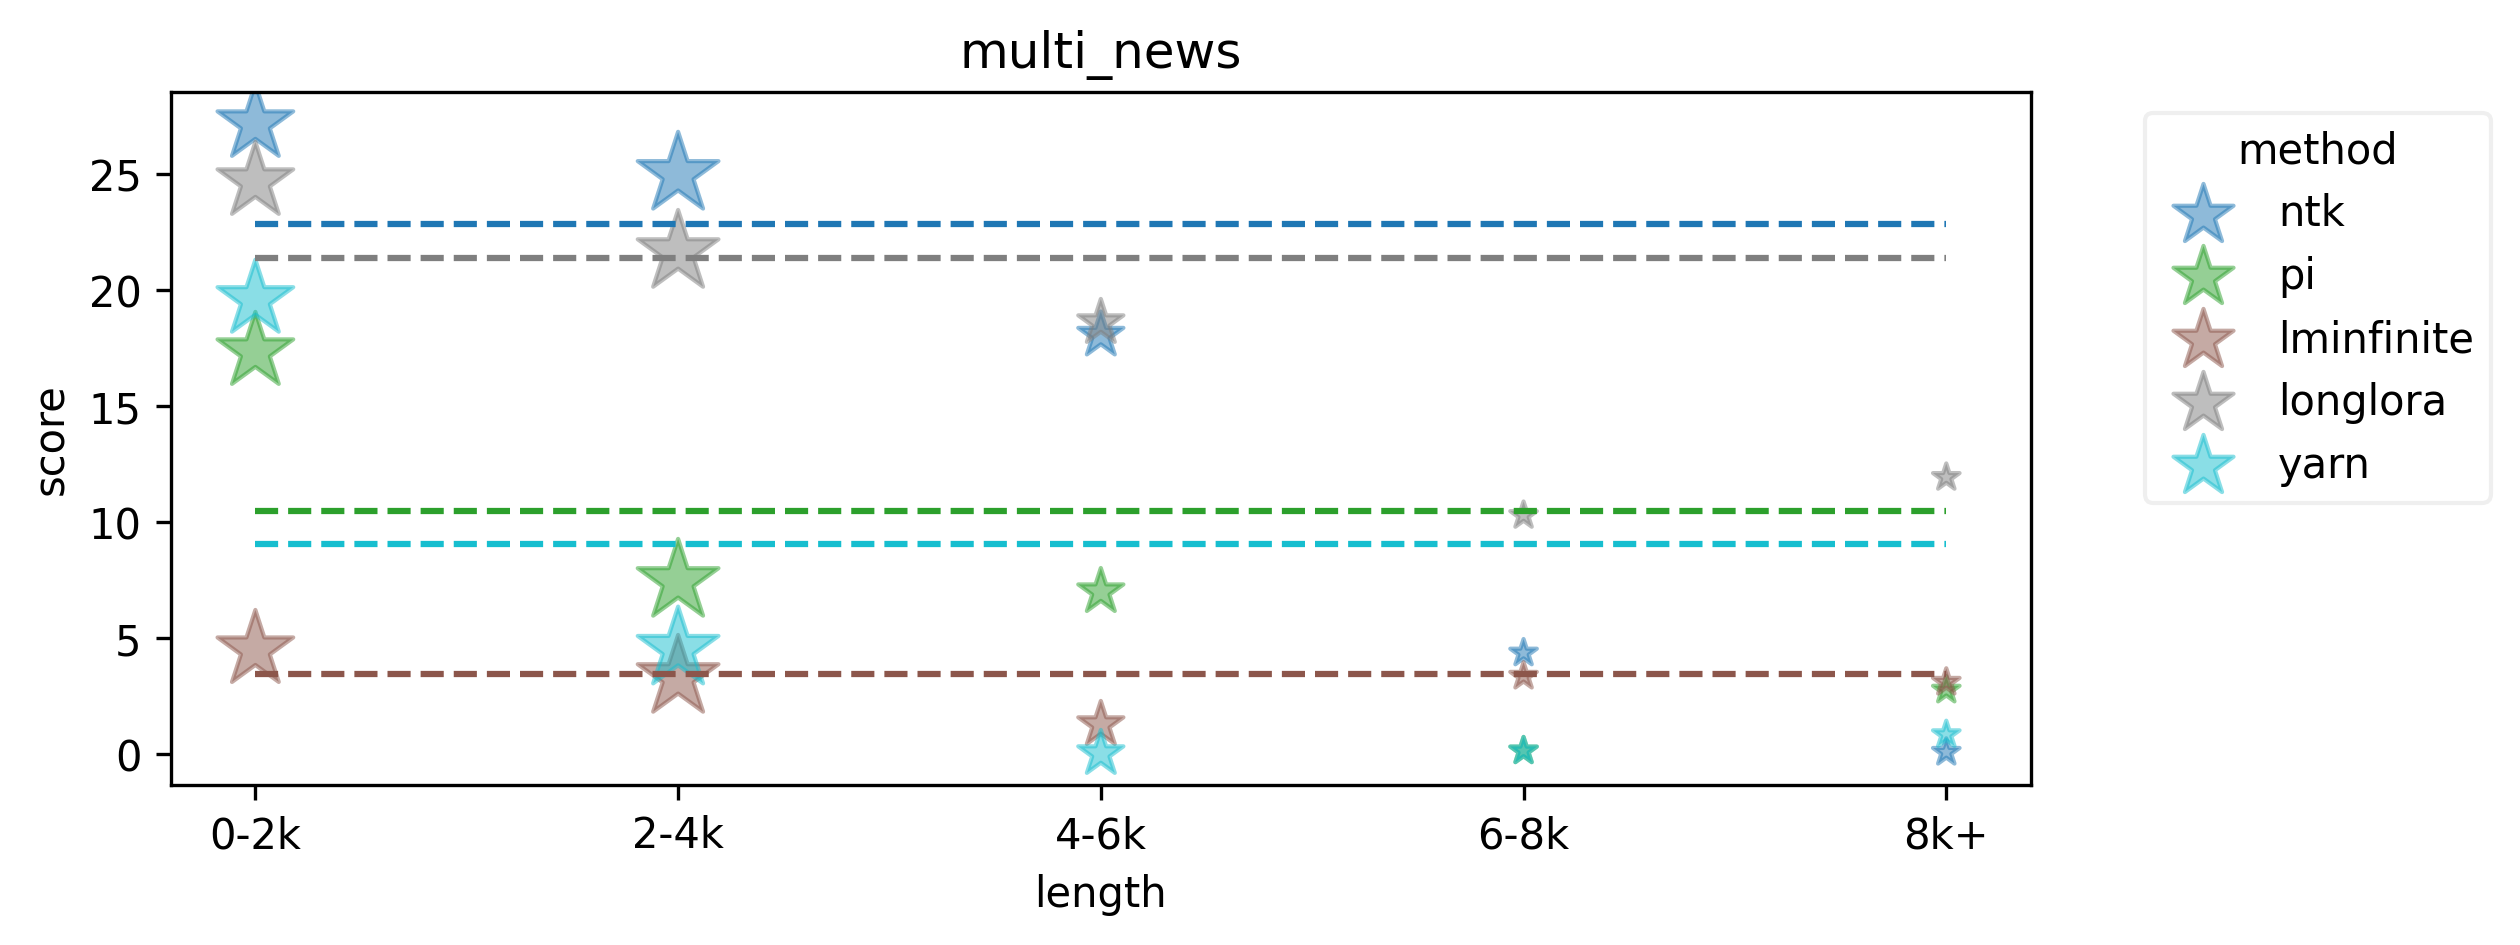

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


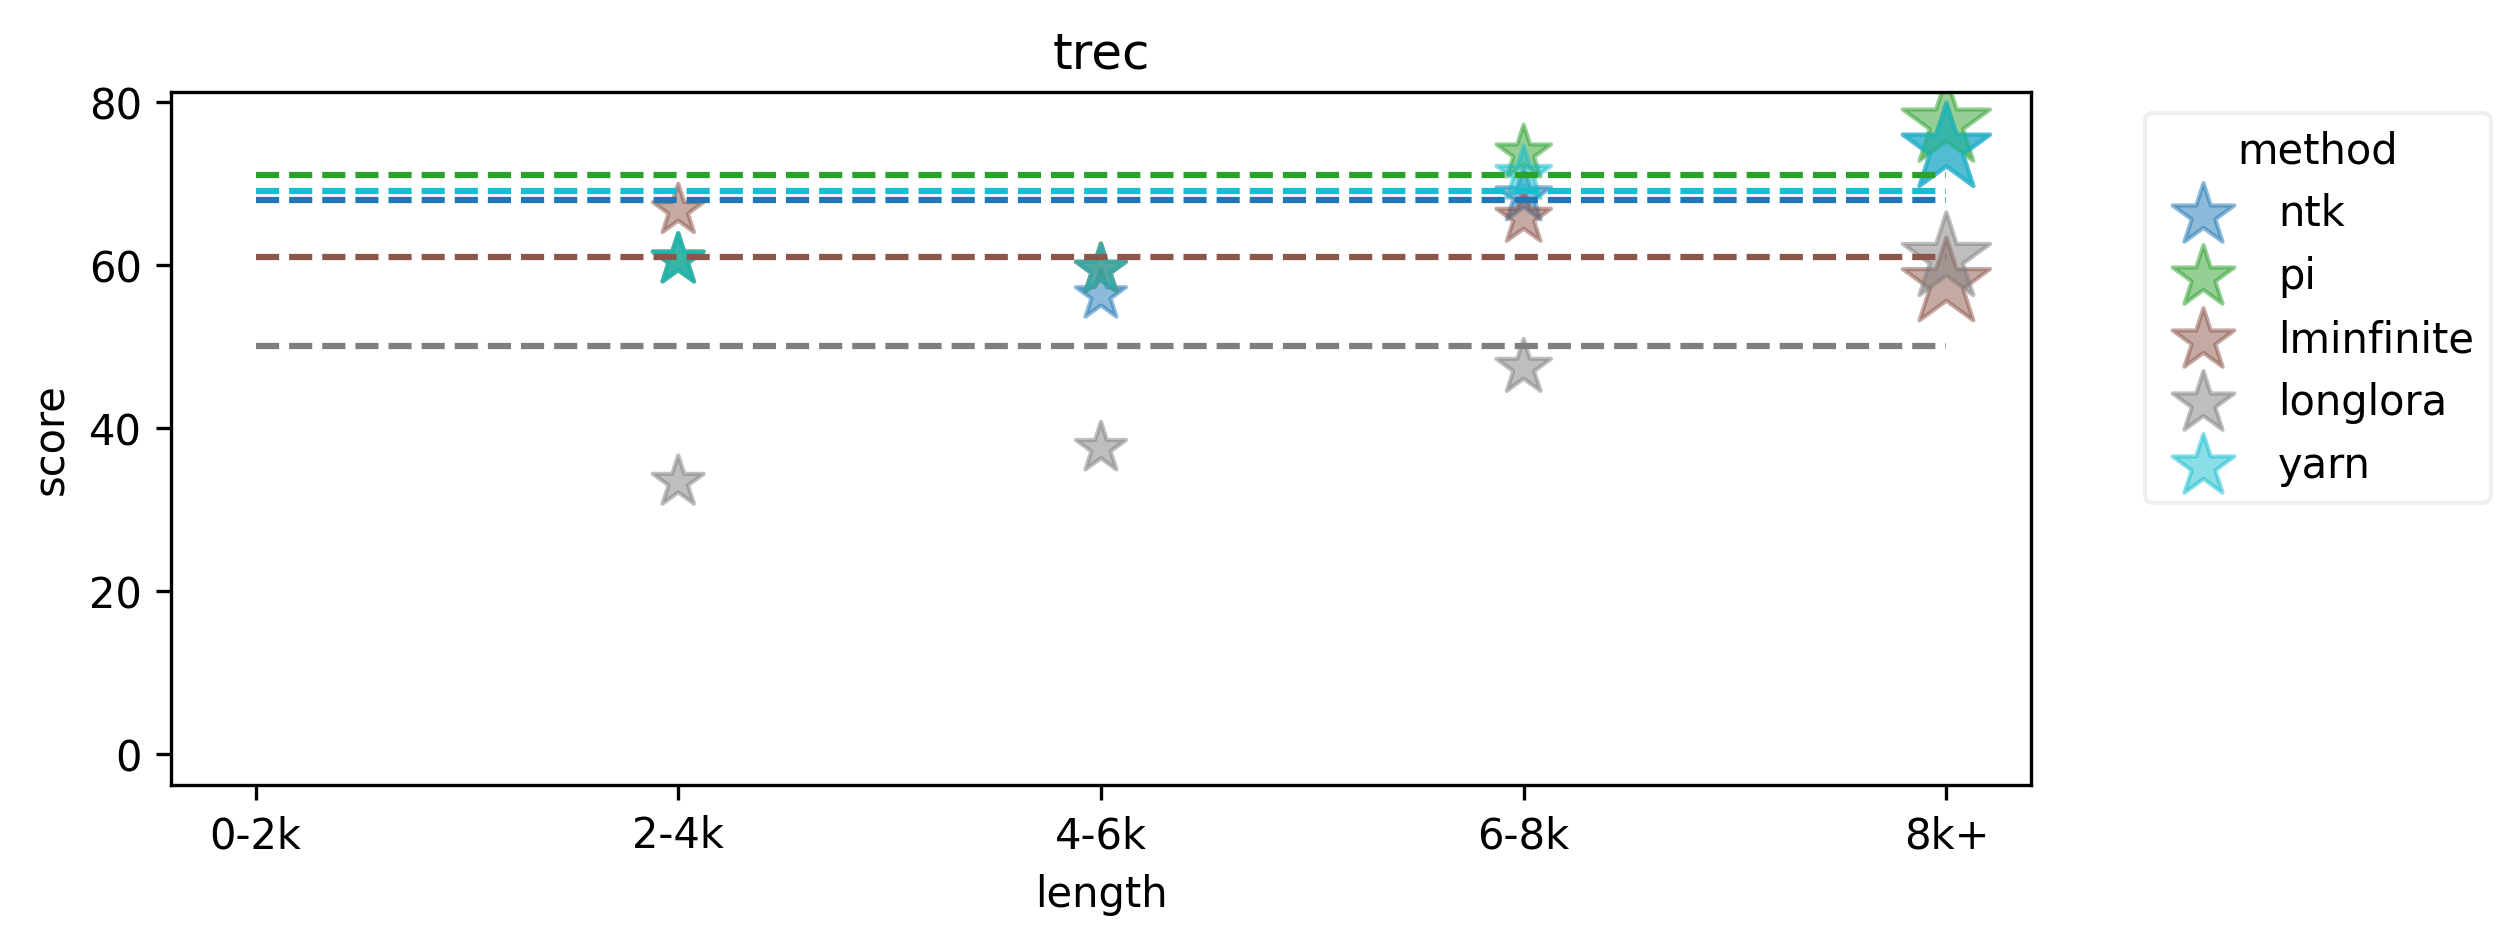

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


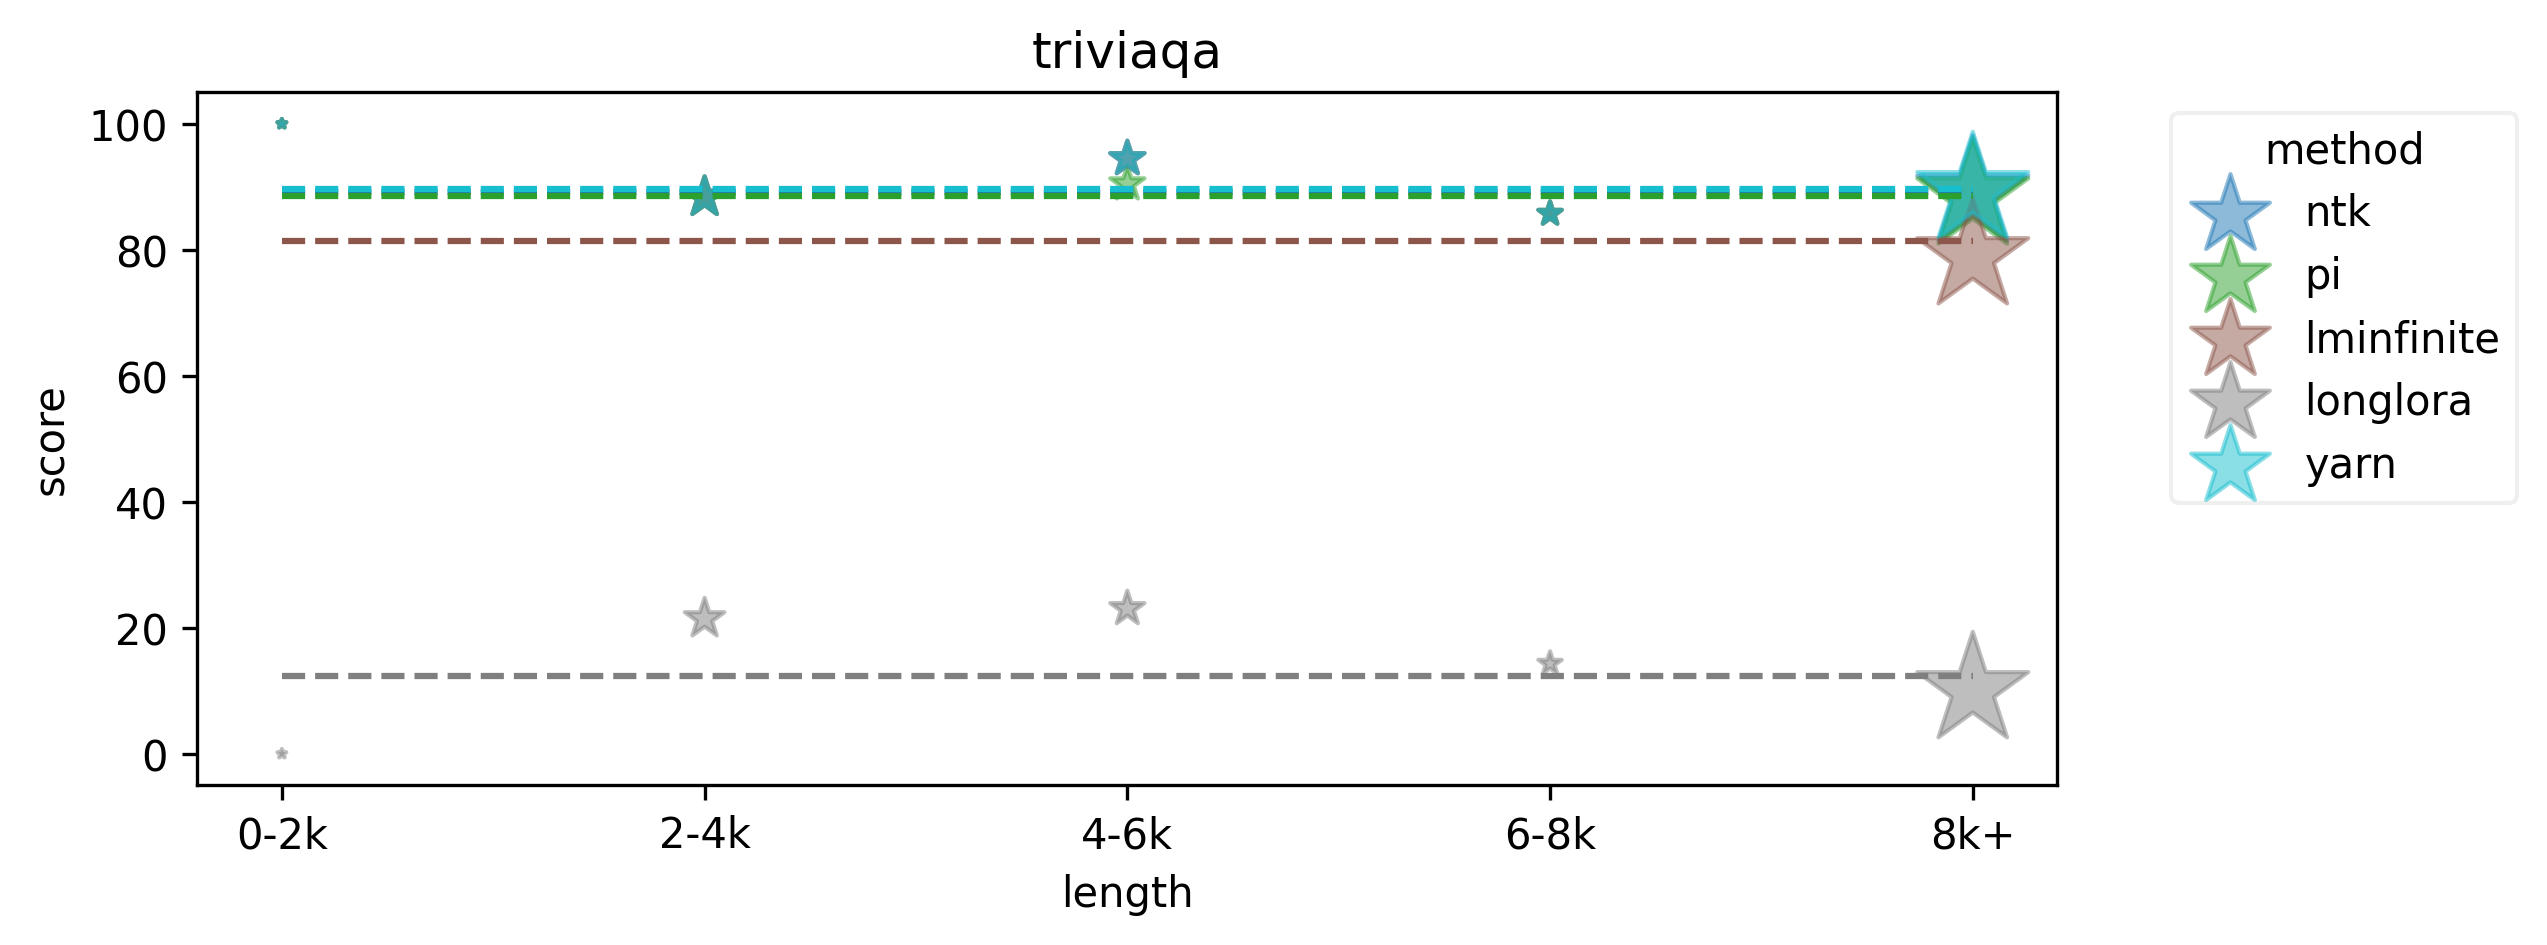

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


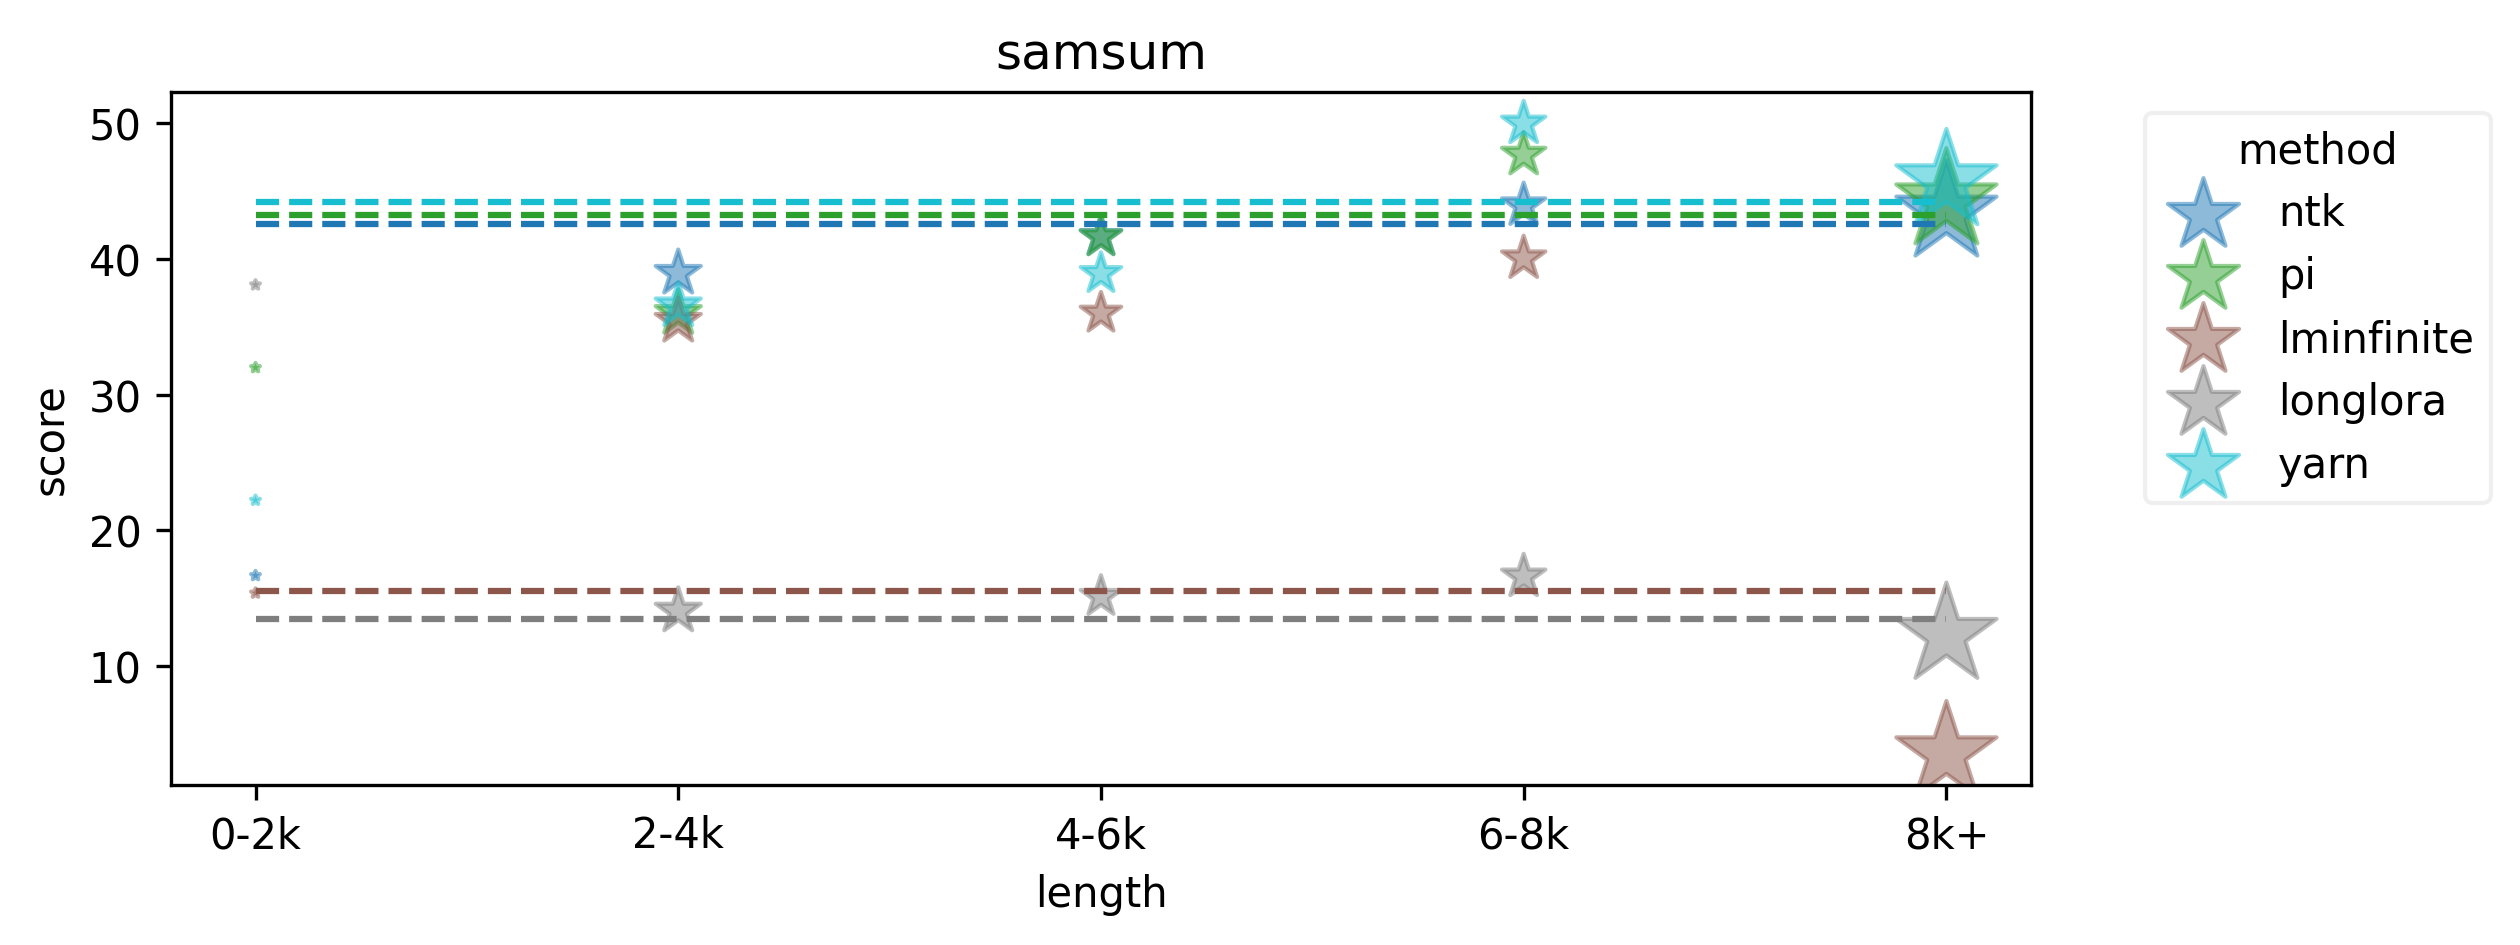

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


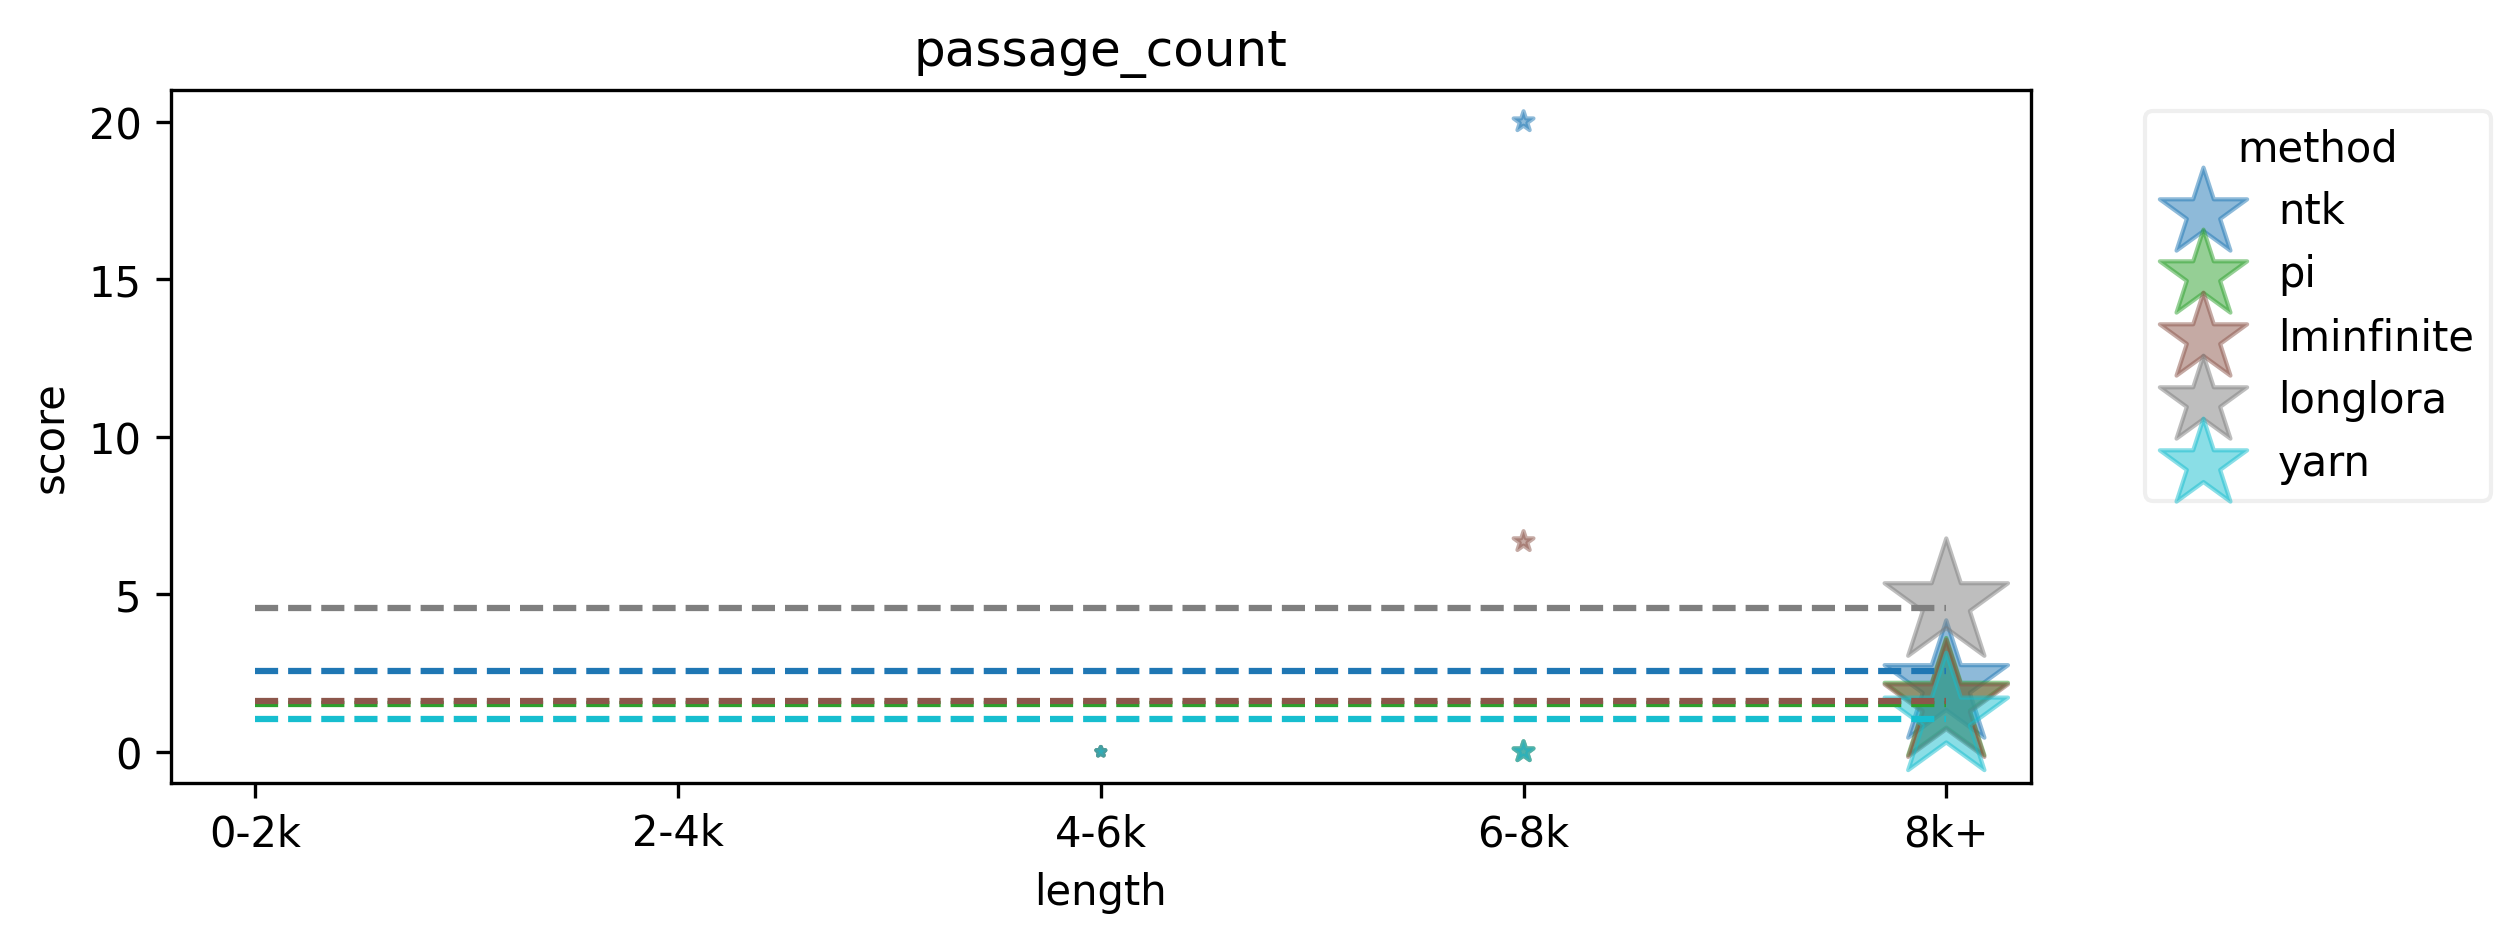

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


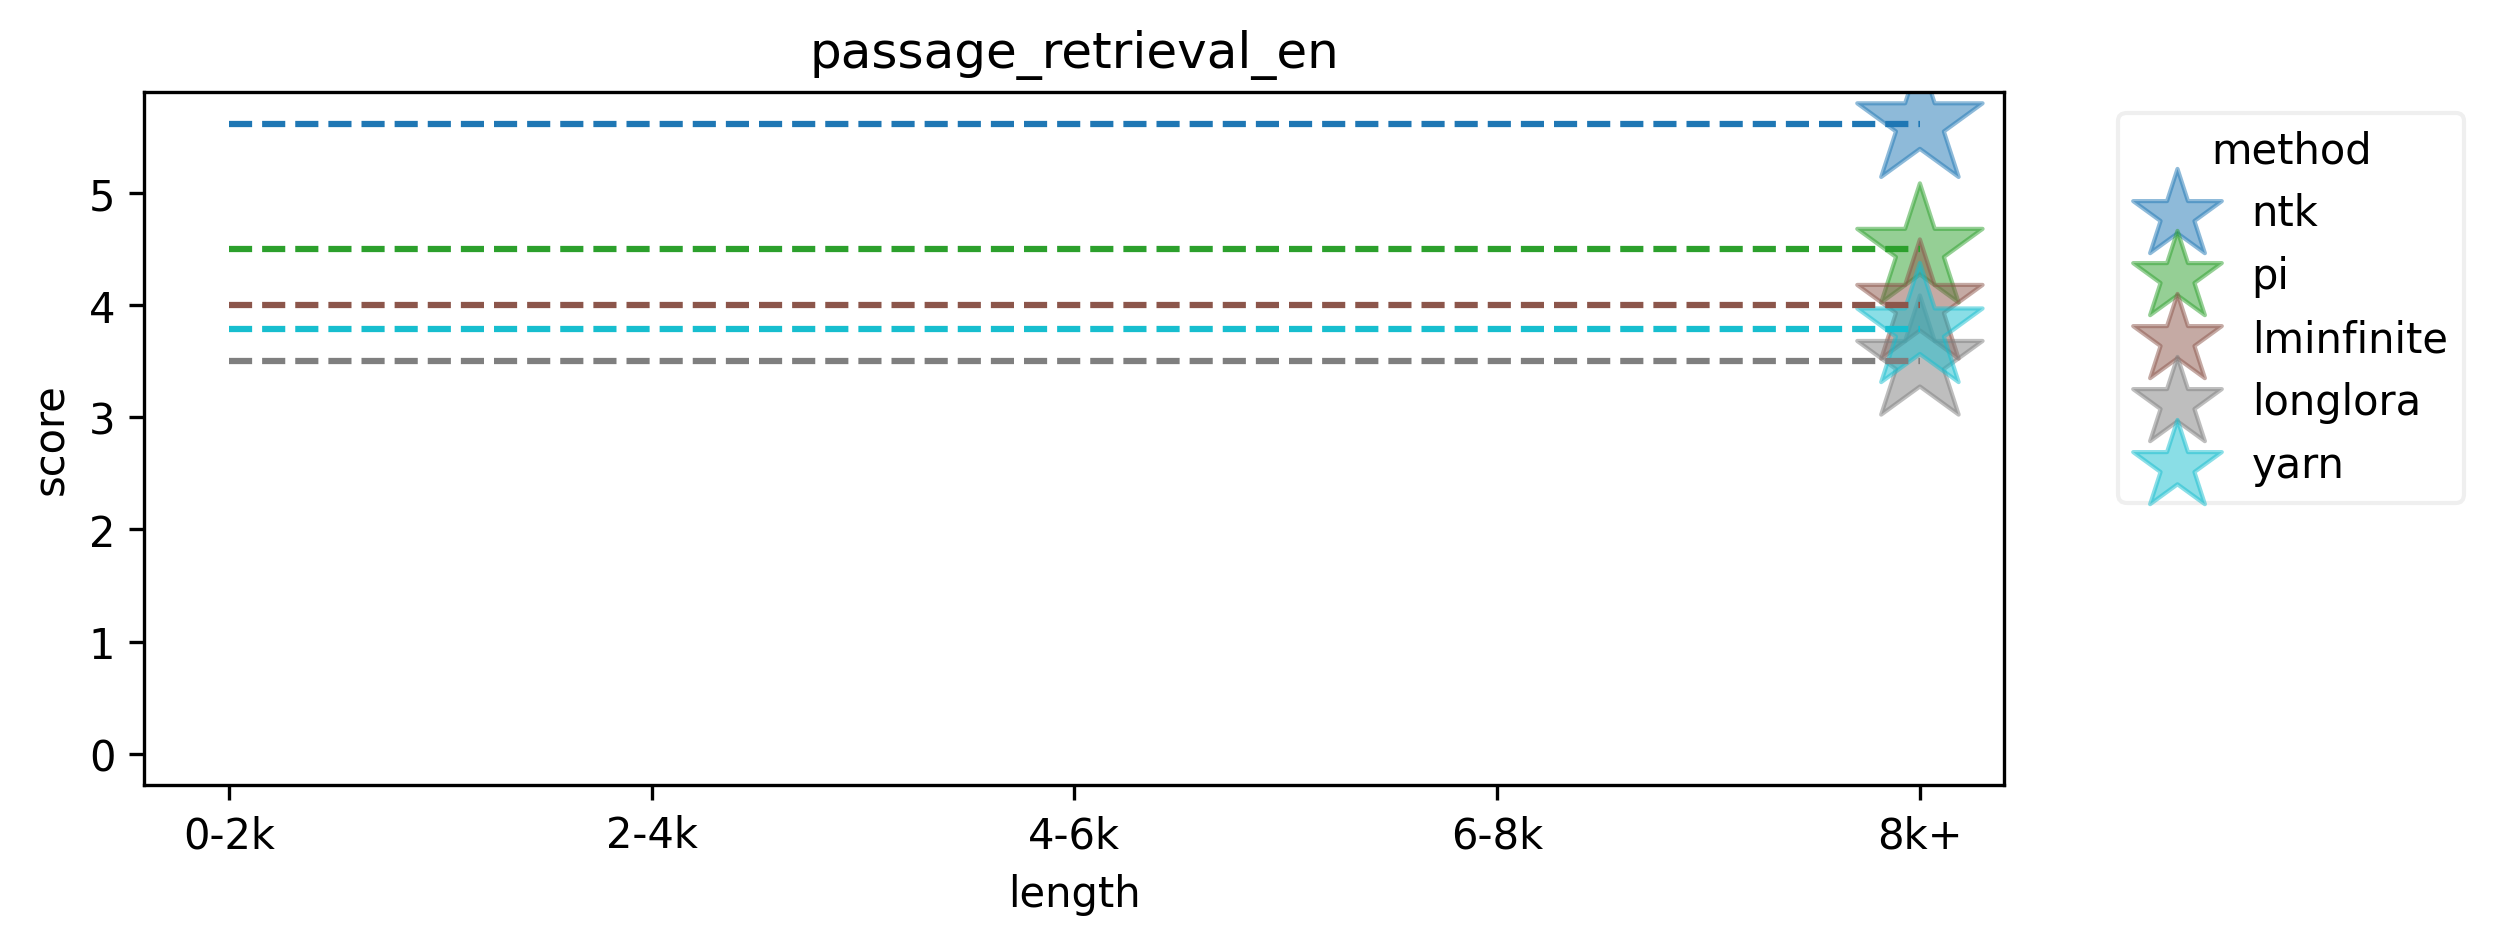

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


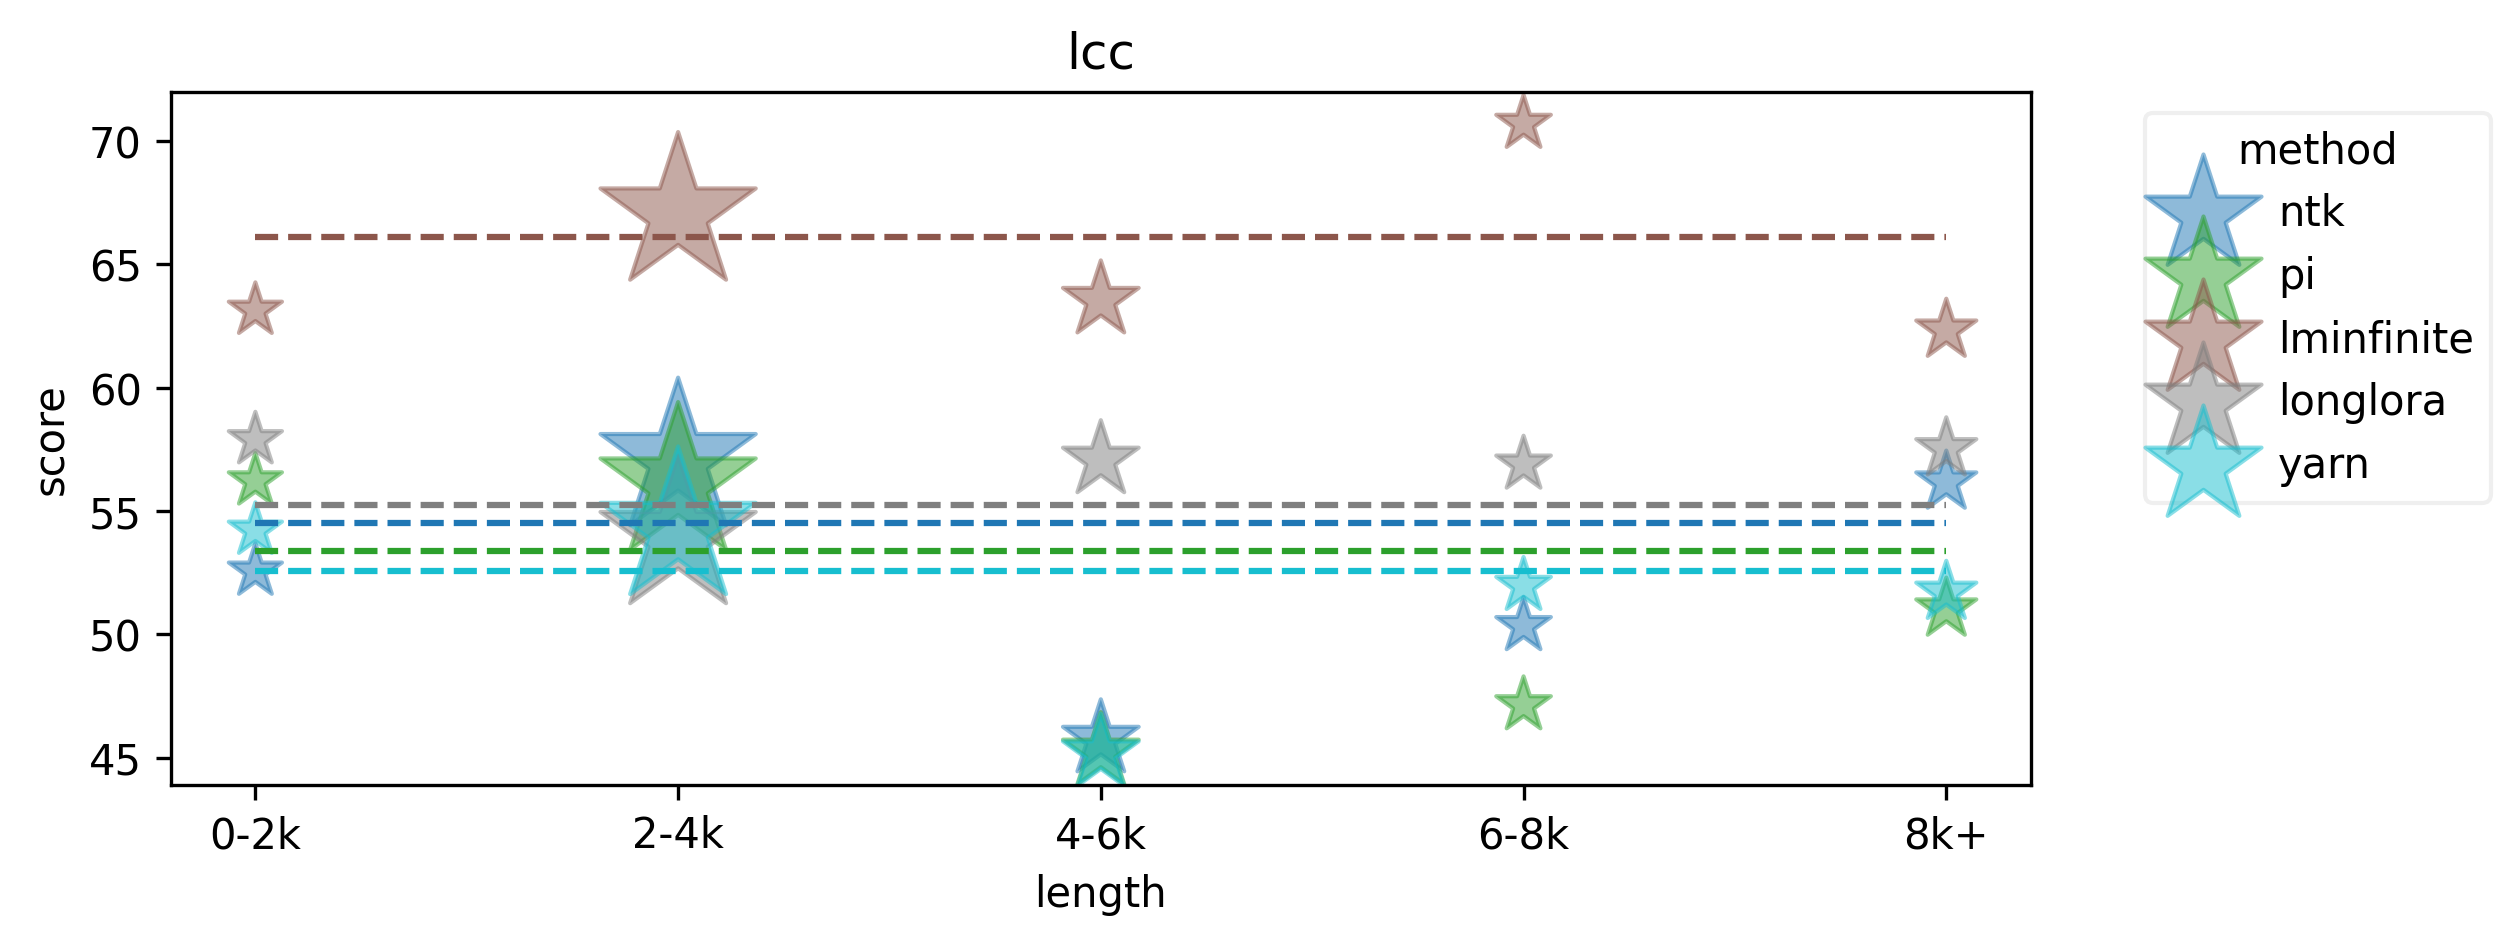

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


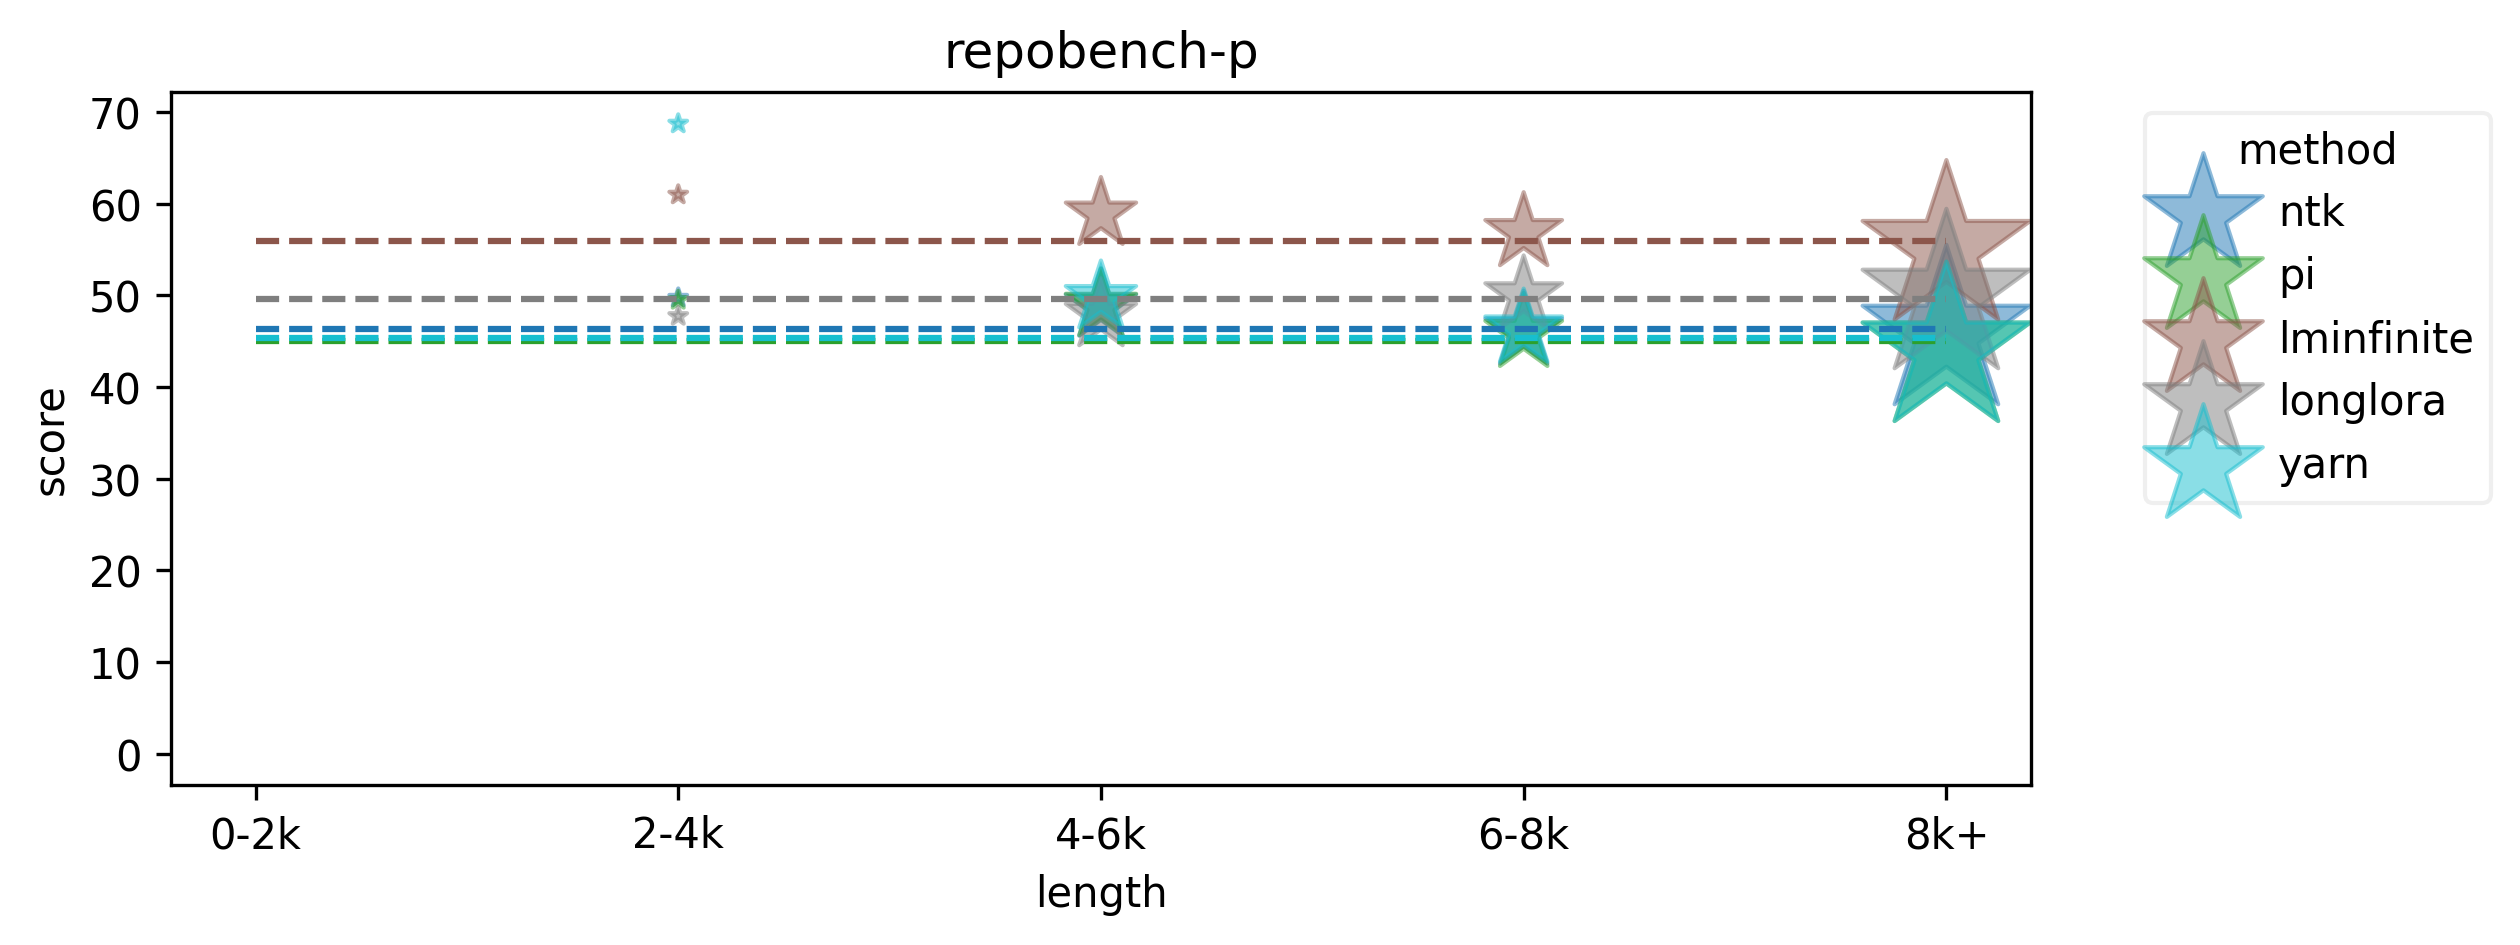

/tmp/ipykernel_177406/450075851.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(model_re.keys()))


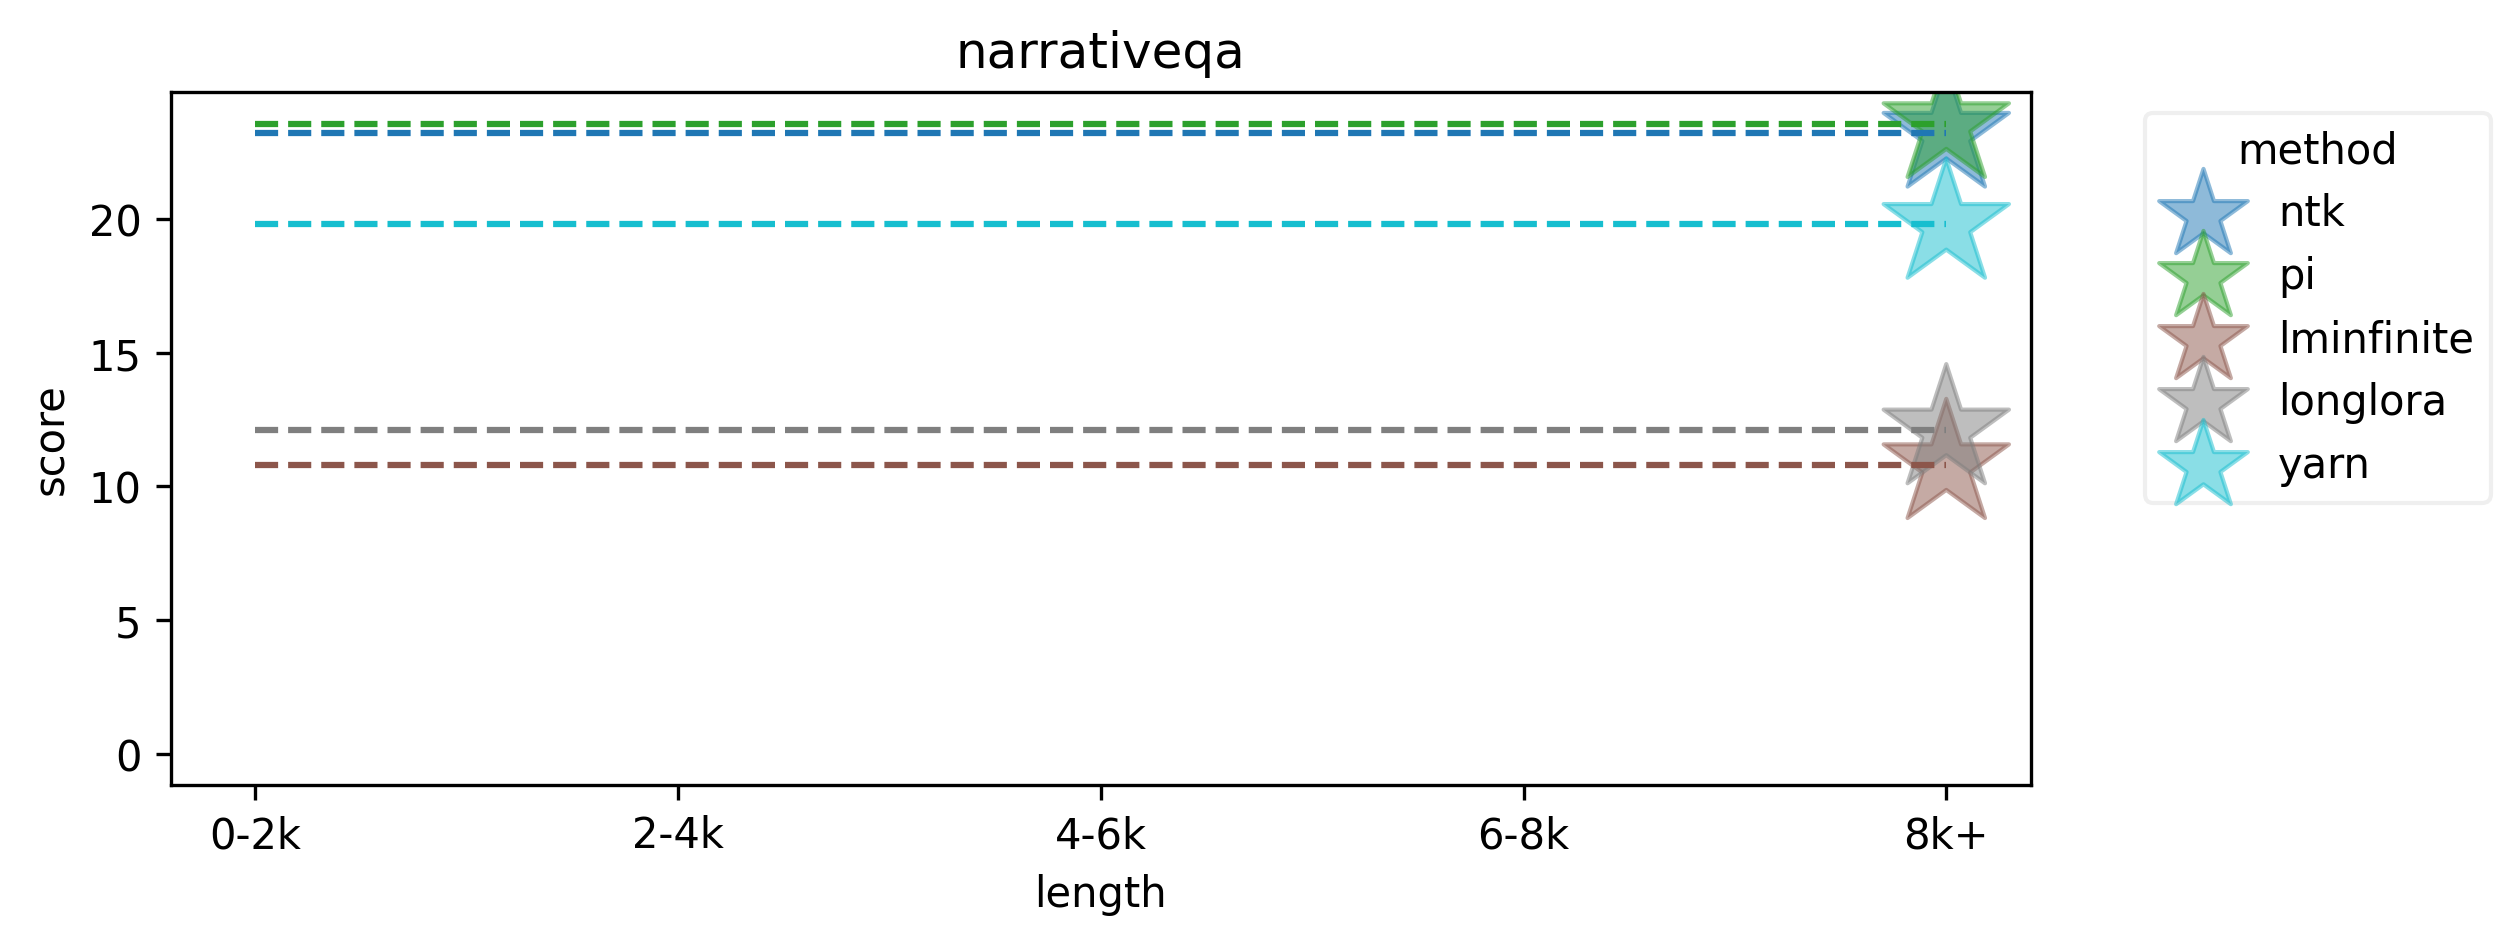

In [9]:
for dataset, model_re in dataset_re.items():
    colors = plt.cm.get_cmap('tab10', len(model_re.keys()))
    plt.figure(figsize=(8, 3), dpi=300)
    for i, (model, res) in enumerate(model_re.items()):
        x, y, sizes = [s[0]*1000 for s in res],[s[1] for s in res],[s[2]*5 for s in res]
        # plt.plot(x, y, color=colors(i), label=model)
        plt.plot(x, [results_all[model][dataset]]*len(x), linestyle='--', color=colors(i))
        plt.scatter(x, y, s=sizes, color=colors(i), marker='*' ,alpha=0.5,  label=model)
    plt.title(dataset)
    plt.xticks([v*1000 for v in x_map.values()], list(x_map.keys()))
    plt.xlabel("length")
    plt.ylabel("score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="method", framealpha=0.3)
    plt.show()

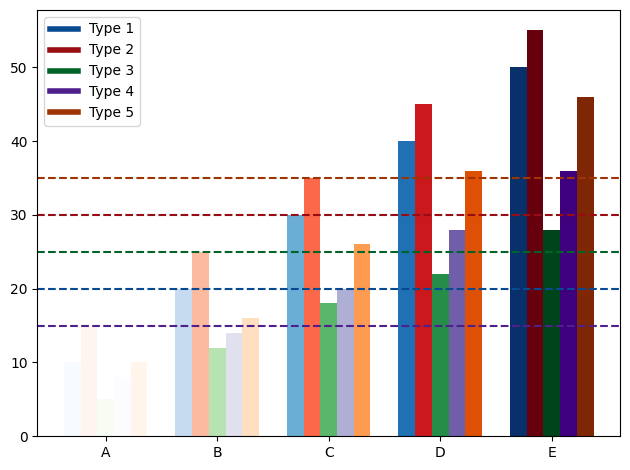

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
categories = ['A', 'B', 'C', 'D', 'E']
values_type1 = [10, 20, 30, 40, 50]  # 种类 1 的数据
values_type2 = [15, 25, 35, 45, 55]  # 种类 2 的数据
values_type3 = [5, 12, 18, 22, 28]   # 种类 3 的数据
values_type4 = [8, 14, 20, 28, 36]   # 种类 4 的数据
values_type5 = [10, 16, 26, 36, 46]  # 种类 5 的数据

# 基线值
baselines = [20, 30, 25, 15, 35]

# 创建颜色映射
norm1 = plt.Normalize(min(values_type1), max(values_type1))
norm2 = plt.Normalize(min(values_type2), max(values_type2))
norm3 = plt.Normalize(min(values_type3), max(values_type3))
norm4 = plt.Normalize(min(values_type4), max(values_type4))
norm5 = plt.Normalize(min(values_type5), max(values_type5))

# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

cmap1 = plt.get_cmap('Blues')
cmap2 = plt.get_cmap('Reds')
cmap3 = plt.get_cmap('Greens')
cmap4 = plt.get_cmap('Purples')
cmap5 = plt.get_cmap('Oranges')

# 获取颜色，并选取较深的颜色
colors_type1 = cmap1(norm1(values_type1))
colors_type2 = cmap2(norm2(values_type2))
colors_type3 = cmap3(norm3(values_type3))
colors_type4 = cmap4(norm4(values_type4))
colors_type5 = cmap5(norm5(values_type5))

# 定义柱状图的宽度
bar_width = 0.15

# 定义x轴位置
index = np.arange(len(categories))

# 创建图形和子图
fig, ax = plt.subplots()

# 绘制柱状图，分别为五种类型
ax.bar(index, values_type1, bar_width, color=colors_type1, label='Type 1')
ax.bar(index + bar_width, values_type2, bar_width, color=colors_type2, label='Type 2')
ax.bar(index + 2 * bar_width, values_type3, bar_width, color=colors_type3, label='Type 3')
ax.bar(index + 3 * bar_width, values_type4, bar_width, color=colors_type4, label='Type 4')
ax.bar(index + 4 * bar_width, values_type5, bar_width, color=colors_type5, label='Type 5')

# 添加类别标签
ax.set_xticks(index + 2 * bar_width)
ax.set_xticklabels(categories)

# 绘制5条贯穿整个图的基线，并且每条基线对应各个种类的颜色
colors_for_baselines = [cmap1(0.9), cmap2(0.9), cmap3(0.9), cmap4(0.9), cmap5(0.9)]
for i, baseline in enumerate(baselines):
    ax.axhline(y=baseline, color=colors_for_baselines[i], linestyle='--', label=f'Baseline {categories[i]}')

# 手动设置图例颜色，使用较深的颜色
legend_colors = [cmap1(0.9), cmap2(0.9), cmap3(0.9), cmap4(0.9), cmap5(0.9)]
legend_labels = ['Type 1', 'Type 2', 'Type 3', 'Type 4', 'Type 5']

# 创建自定义图例，用加深的颜色
handles = [plt.Line2D([0], [0], color=legend_colors[i], lw=4) for i in range(len(legend_labels))]
ax.legend(handles, legend_labels)

# 调整布局
plt.tight_layout()

# 显示图像
plt.show()